# Problem statement
This report is written in the shoes of football club managers and aims to use both on-field and off-field statistics to build a dream squad consisting of the most competent players to date. The business task can be viewed as a candidate-position assignment problem in the field of optimization research. We solved the optimization problem under two different scenarios – with an unlimited budget and with a budget constraint respectively. To give an accurate estimation of key parameters in the optimization formula such as player market value and the cost of position transition, we will first predict the most suitable position for a certain player using classification and then forecast his expected wage using regression. Finally, with the predicted values, we will optimise the objective function with corresponding constraints to find our dream squad.

# Preamble and Packages

In [1]:
import os
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(20,8)})
%matplotlib inline
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

# Classification Data prepocessing

In [2]:
fifa = pd.read_csv(r'data.csv',index_col=None, header=0)

In [3]:
fifa['General_position'] = 'Mid'
Def = ['LWB','RWB','LB','RB','RCB','LCB','CB']
For = ['LF','RF','CF','ST','LS','RS']

In [4]:
for i in range(0,len(fifa)):
    if fifa.loc[i,'Position'] in Def:
        fifa.loc[i,'General_position'] = 'Def'
    if fifa.loc[i,'Position'] in For:
        fifa.loc[i,'General_position'] = 'For'
    if fifa.loc[i,'Position'] == 'GK':
        fifa.loc[i,'General_position'] = 'GK'

In [5]:
fifa.drop(['Unnamed: 0','Photo','Flag','Club Logo','Jersey Number','Joined','Contract Valid Until','LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'GK', 'Likes', 'Dislikes', 'Following'],axis=1,inplace=True)

In [6]:
fifa.head()

ID                  Name  Age    Nationality  Overall  Potential  \
0  253283     Facundo Pellistri   18        Uruguay       71         87   
1  179813        Edinson Cavani   32        Uruguay       86         86   
2  245541        Giovanni Reyna   17  United States       68         87   
3  233419  Raphael Dias Belloli   23         Brazil       81         85   
4  198710       James Rodríguez   28       Colombia       82         82   

                  Club       Value      Wage  Special       ...         \
0              Peñarol   4900000.0     500.0     1729       ...          
1  Paris Saint-Germain  35500000.0  150000.0     2144       ...          
2    Borussia Dortmund   1800000.0    2000.0     1671       ...          
3     Stade Rennais FC  23000000.0   50000.0     2071       ...          
4              Everton  22500000.0  105000.0     2099       ...          

  Composure Defensive Awareness Standing Tackle Sliding Tackle GK Diving  \
0      61.0                35.0            11.0           18.0       9.0   
1      80.0                57.0            48.0           39.0      12.0   
2      59.0                30.0            23.0           24.0      10.0   
3      79.0                45.0            54.0           38.0       8.0   
4      87.0                52.0            41.0           44.0      15.0   

  GK Handling GK Kicking  GK Positioning GK Reflexes General_position  
0        12.0        7.0             8.0         7.0              Mid  
1         5.0       13.0            13.0        10.0              For  
2        13.0       14.0            12.0         7.0              Mid  
3         7.0       13.0             8.0        14.0              Mid  
4        15.0       15.0             5.0        14.0              Mid  

[5 rows x 56 columns]

In [7]:
fifa.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Special', 'Preferred Foot', 'Weak Foot',
       'Skill Moves', 'International Reputation', 'Work Rate', 'Body Type',
       'Real Face', 'Release Clause', 'Position', 'Height', 'Weight',
       'Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'General_position'],
      dtype='object')

# Classification Feature selection

ATTACKING
Crossing
Finishing
Heading Accuracy
Short Passing
Volleys

SKILL
Dribbling
Curve
FK Accuracy
Long Passing
Ball Control

MOVEMENT
Acceleration
Sprint Speed
Agility
Reactions
Balance

POWER
Shot Power
Jumping
Stamina
Strength
Long Shots

MENTALITY
Aggression
Interceptions
Positioning
Vision
Penalties
Composure

DEFENDING
Defensive Awareness
Standing Tackle
Sliding Tackle

GOALKEEPING
GK Diving
GK Handling
GK Kicking
GK Positioning
GK Reflexes

## For each postion, find the top 5 important features

In [59]:
player_features = ('Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
                   'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
                   'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
                   'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
                   'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
                   'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
                   'GK Reflexes')

for i, val in fifa.groupby(fifa['General_position'])[player_features].mean().iterrows():
    print('Position {}: {}, {}, {}, {}, {}'.format(i, *tuple(val.nlargest(5).index)))

Position Def: Strength, Jumping, Stamina, Standing Tackle, Aggression
Position For: Strength, Sprint Speed, Acceleration, Jumping, Shot Power
Position GK: GK Reflexes, GK Diving, GK Positioning, GK Handling, GK Kicking
Position Mid: Balance, Agility, Acceleration, Sprint Speed, Ball Control


In [38]:
stats = fifa.groupby(fifa['General_position'])[player_features].mean()
stats

Crossing  Finishing  Heading Accuracy  Short Passing  \
General_position                                                          
Def               52.203493  36.174961         61.441592      60.574449   
For               48.965030  67.629813         64.176969      60.133263   
GK                14.101449  11.603478         14.225507      27.576232   
Mid               59.829436  56.699261         52.011745      67.177699   

                    Volleys  Dribbling      Curve  FK Accuracy  Long Passing  \
General_position                                                               
Def               36.236599  54.209359  44.784006    39.182469     54.648620   
For               60.110562  64.460396  53.729071    46.078473     47.313670   
GK                11.977391  13.837681  14.773913    14.224928     26.613913   
Mid               52.590657  67.036465  58.645685    53.727597     62.306432   

                  Ball Control     ...       Penalties  Composure  \
General_position                   ...                              
Def                  59.172811     ...       43.883863  59.169313   
For                  65.653696     ...       64.042064  62.002918   
GK                   20.054524     ...       19.602319  43.276923   
Mid                  68.024039     ...       55.958559  62.816961   

                  Defensive Awareness  Standing Tackle  Sliding Tackle  \
General_position                                                         
Def                         63.989664        66.888131       65.246377   
For                         29.087379        26.495231       23.727658   
GK                          14.439574        14.037101       13.889275   
Mid                         48.599711        49.825215       47.062549   

                  GK Diving  GK Handling  GK Kicking  GK Positioning  \
General_position                                                       
Def               10.456958    10.485071   10.403772       10.437751   
For               10.331332    10.504415   10.540445       10.379371   
GK                66.626597    64.353694   62.988953       64.850494   
Mid               10.364344    10.444444   10.442069       10.394563   

                  GK Reflexes  
General_position               
Def                 10.383796  
For                 10.487813  
GK                  67.632464  
Mid                 10.365928  

[4 rows x 34 columns]

## Find most possible features to distinguish positions

### Def VS For

In [39]:
stats.iloc[0].subtract(stats.iloc[1]).nlargest(5)

Sliding Tackle         41.518719
Standing Tackle        40.392900
Interceptions          37.634972
Defensive Awareness    34.902285
Aggression             11.840248
dtype: float64

In [40]:
stats.iloc[0].subtract(stats.iloc[1]).nsmallest(5)

Finishing     -31.454852
Volleys       -23.873963
Positioning   -21.437528
Long Shots    -20.848154
Penalties     -20.158201
dtype: float64

### Def VS Mid

In [41]:
stats.iloc[0].subtract(stats.iloc[3]).nlargest(5)

Sliding Tackle         18.183827
Standing Tackle        17.062917
Interceptions          16.049444
Defensive Awareness    15.389952
Heading Accuracy        9.429848
dtype: float64

In [42]:
stats.iloc[0].subtract(stats.iloc[3]).nsmallest(5)

Finishing     -20.524300
Long Shots    -18.711479
Volleys       -16.354059
Vision        -16.112013
Positioning   -15.385368
dtype: float64

### For VS Mid

In [43]:
stats.iloc[1].subtract(stats.iloc[3]).nlargest(5)

Heading Accuracy    12.165225
Finishing           10.930552
Strength             8.808026
Penalties            8.083506
Volleys              7.519904
dtype: float64

In [44]:
stats.iloc[1].subtract(stats.iloc[3]).nsmallest(5)

Sliding Tackle        -23.334891
Standing Tackle       -23.329983
Interceptions         -21.585528
Defensive Awareness   -19.512333
Long Passing          -14.992762
dtype: float64

### First select 23 features out of 34 features
Jumping, Stamina, Strength, Sprint Speed, Acceleration, GK Reflexes, Agility, 
Sliding Tackle,Standing Tackle,Interceptions, Finishing, Volleys, Positioning, Long Shots, Heading Accuracy, Aggression, Shot Power, Balance, Ball Control, Defensive Awareness, Penalties, Vision, Long Passing

In [47]:
features = ['Jumping', 'Stamina', 'Strength', 'Sprint Speed', 'Acceleration', 'GK Reflexes'
            ,'Agility', 'Sliding Tackle', 'Standing Tackle','Interceptions', 'Finishing', 'Volleys', 'Positioning',
            'Long Shots', 'Heading Accuracy', 'Aggression', 'Shot Power', 'Balance', 'Ball Control', 'Defensive Awareness', 
            'Penalties', 'Vision', 'Long Passing']

## Remove highly correlated ones

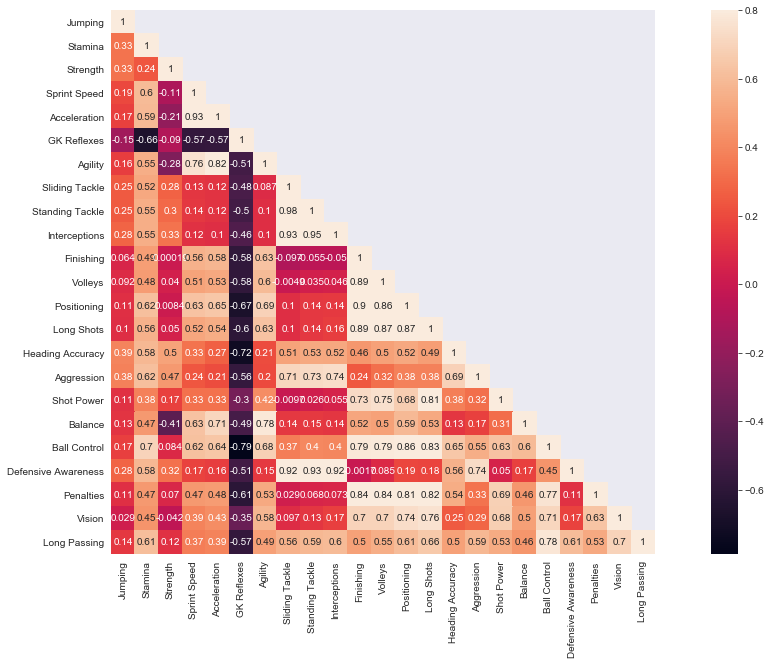

In [48]:
# Correlation Matrix
corrMatt = fifa[features].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

### Finnally Select 17 features out of 34 features

In [8]:
features = ['Jumping', 'Stamina', 'Strength', 'Acceleration', 'GK Reflexes'
            ,'Agility', 'Sliding Tackle', 'Volleys', 'Positioning',
            'Heading Accuracy', 'Aggression', 'Shot Power', 'Balance', 'Ball Control', 
            'Penalties', 'Vision', 'Long Passing']

## Drop NA

In [9]:
fifa = fifa.dropna(subset=features)

# Classification Models Building

In [11]:
#fifa['rate_gap'] = fifa['Potential']-fifa['Overall']
#candidates = fifa.groupby('General_position').apply(lambda x: x.sort_values(by = 'rate_gap', ascending = False).head(50))

In [12]:
#outputpath='candidates.csv'
#candidates.to_csv(outputpath,sep=',')

In [13]:
fifa.groupby(['General_position'])['ID'].count()

General_position
Def    5722
For    2828
GK     1715
Mid    7565
Name: ID, dtype: int64

### Need stratified test train split

In [10]:
y = fifa['General_position']
X = fifa[features]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Decision tree classifier

In [68]:
kf =KFold(n_splits=10, shuffle=True, random_state=42)
max_attributes = len(list(X_train))
max_depth = range(1, max_attributes + 1)

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.541
Average score(2): 0.727
Average score(3): 0.799
Average score(4): 0.830
Average score(5): 0.843
Average score(6): 0.853
Average score(7): 0.856
Average score(8): 0.857
Average score(9): 0.857
Average score(10): 0.854
Average score(11): 0.849
Average score(12): 0.844
Average score(13): 0.839
Average score(14): 0.837
Average score(15): 0.831
Average score(16): 0.830
Average score(17): 0.828


In [69]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=8)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render()

'Source.gv.pdf'

1. **Sliding tackle can identify Def,For,GK from each other**

2. **Sliding tackle+Positioning can identify GK from others**

3. **Sliding tackle+Finishing can indentify Mid from others**

In [39]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(X_train, y_train)
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render()

'Source.gv.pdf'

## Evaluation

In [71]:
dt.score(X_test,y_test)

0.8525695029486099

In [ ]:
#predictions = dt.predict(test)

## Random forest

In [72]:
n_estimators = [50, 100, 150, 200, 250, 300, 350]

for val in n_estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42), X_train, y_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(50): 0.890
Average score(100): 0.889
Average score(150): 0.891
Average score(200): 0.891
Average score(250): 0.892
Average score(300): 0.891
Average score(350): 0.891


In [57]:
rf = RandomForestClassifier(n_estimators= 150, random_state= 42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Evaluation

In [58]:
rf.score(X_test,y_test)

0.8911946158160404

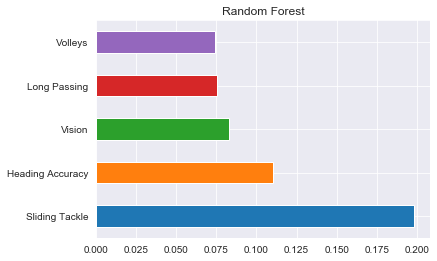

In [59]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Random Forest')
plt.show()

In [76]:
feat_importances.nlargest(5)

Sliding Tackle      0.200130
Heading Accuracy    0.109416
Vision              0.081994
Volleys             0.078798
Positioning         0.076722
dtype: float64

## Boosting - XGBoost

Objective - what is your objective for this particular problem, here we are having a multiclass classficiation problem hence multi softmax

n_estimators - number of trees we are using for classification problem

learning_rate - how big a step to take

max_depth - maximum depth of each trees

colsample_bytree - how much percent of the features to be by each tree

subsample - How much percent of the data used by each tree

In [81]:
n_estimators = [50, 100, 150, 200, 250]
rate = [0.1, 0.15, 0.2]
depth = [4, 5, 6]

for val1 in n_estimators:
    for val2 in rate:
        for val3 in depth:
            score = cross_val_score(xgb.XGBClassifier(objective='multi:softmax', n_estimators=val1,learning_rate=val2,
                                          max_depth=val3), X_train, y_train, cv= kf, scoring="accuracy")
            print(f'Average score({val1},{val2},{val3}): {"{:.3f}".format(score.mean())}')


Average score(50,0.1,4): 0.884
Average score(50,0.1,5): 0.887
Average score(50,0.1,6): 0.887
Average score(50,0.15,4): 0.887
Average score(50,0.15,5): 0.890
Average score(50,0.15,6): 0.890
Average score(50,0.2,4): 0.889
Average score(50,0.2,5): 0.890
Average score(50,0.2,6): 0.890
Average score(100,0.1,4): 0.889
Average score(100,0.1,5): 0.890
Average score(100,0.1,6): 0.891
Average score(100,0.15,4): 0.892
Average score(100,0.15,5): 0.891
Average score(100,0.15,6): 0.891
Average score(100,0.2,4): 0.892
Average score(100,0.2,5): 0.892
Average score(100,0.2,6): 0.891
Average score(150,0.1,4): 0.891
Average score(150,0.1,5): 0.891
Average score(150,0.1,6): 0.892
Average score(150,0.15,4): 0.893
Average score(150,0.15,5): 0.892
Average score(150,0.15,6): 0.892
Average score(150,0.2,4): 0.892
Average score(150,0.2,5): 0.891
Average score(150,0.2,6): 0.891
Average score(200,0.1,4): 0.892
Average score(200,0.1,5): 0.892
Average score(200,0.1,6): 0.892
Average score(200,0.15,4): 0.894
Average

In [54]:
xg = xgb.XGBClassifier(objective='multi:softmax', n_estimators=150,learning_rate=0.15,
                          max_depth=4,colsample_bytree=1,subsample=1)
xg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation

In [55]:
xg.score(X_test,y_test)

0.8962422882781829

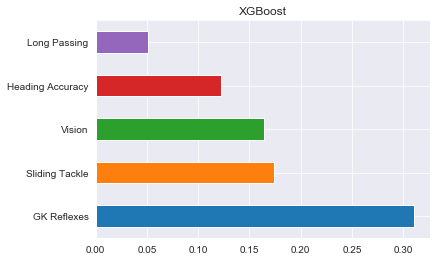

In [56]:
feat_importances = pd.Series(xg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('XGBoost')
plt.show()

In [24]:
feat_importances.nlargest(5)

GK Reflexes         0.311023
Sliding Tackle      0.173895
Vision              0.164325
Heading Accuracy    0.122621
Long Passing        0.051411
dtype: float32

## Predict

In [53]:
cad = pd.read_csv(r'candidates.csv',index_col=None, header=0,encoding = 'cp1252')

In [55]:
cad_X = cad[features]

In [56]:
pred = xg.predict(cad_X)
cad['predict_position'] = pred

In [57]:
outputpath='position_prediction.csv'
#cad.to_csv(outputpath,sep=',')

## Logistic

In [13]:
lg=LogisticRegression(max_iter=1000)
lg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
lg.score(X_test,y_test)

0.8833426808749298

In [22]:
lg.coef_

array([[ 0.03530571,  0.09337844, -0.07644125,  0.14996767, -0.32893033,
         0.05391726,  0.28749131,  0.05022954,  0.05977437,  0.16428696,
        -0.04606075, -0.07996272, -0.08452114,  0.03331465,  0.06541595,
        -0.1531678 , -0.08796319],
       [ 0.03467987,  0.09445576, -0.05992924,  0.08211467, -0.31314658,
         0.02848219, -0.02907554,  0.12206764,  0.16076193,  0.18808844,
        -0.0056704 , -0.07477958, -0.05085216, -0.01023669,  0.10882679,
        -0.10958047, -0.068214  ],
       [-0.09124706, -0.29142148,  0.22635376, -0.33833301,  0.97438356,
        -0.11935061, -0.29342022, -0.23430208, -0.25093509, -0.46354644,
         0.05699786,  0.21231256,  0.19395113, -0.10659049, -0.24739816,
         0.30172898,  0.13250441],
       [ 0.02126149,  0.10358728, -0.08998327,  0.10625066, -0.33230665,
         0.03695116,  0.03500445,  0.06200489,  0.03039879,  0.11117104,
        -0.0052667 , -0.05757027, -0.05857783,  0.08351253,  0.07315542,
        -0.0389807 

## SVM

In [25]:
svm=SVC(kernel="linear")
svm.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
svm.score(X_test,y_test)

0.8869882220975883

# EDA of FIFA Dataset and XGBoost

In [177]:
data20=fifa.copy()

In [339]:
data20.describe().T.to_csv('describe.csv')

In [107]:
data20.drop(['Unnamed: 0','Photo','Flag','Club Logo','LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'GK'],axis=1,inplace=True)

In [108]:
data20.isnull().sum()

ID                 0
Name               0
Age                0
Nationality        0
Overall            0
                  ..
GK Diving         30
GK Handling       32
GK Kicking        32
GK Positioning    34
GK Reflexes       36
Length: 61, dtype: int64

In [10]:
print('Total number of countries : {0}'.format(data20['Nationality'].nunique()))
print(data20['Nationality'].value_counts().head(10))

Total number of countries : 170
England        1856
Germany        1245
Spain          1212
France         1053
Brazil          942
Argentina       842
Italy           616
Netherlands     496
Portugal        386
Mexico          373
Name: Nationality, dtype: int64


 1. Which features are highly correlated with a player’s overall rating by player position
 2. Analyse the differences between a player’s current rating and their potential rating
 3. which teams have the highest potential
 4. the youngest teams / oldest teams
 

In [14]:
data20['Position'].isnull().value_counts()

False    18516
True        25
Name: Position, dtype: int64

In [15]:
data20.dropna(subset=['Position'],inplace=True)

In [16]:
data20['Position'].isnull().value_counts()

False    18516
Name: Position, dtype: int64

In [61]:
#data20['Position'].str.replace('GK', 'gk')
df_gk=data20.loc[data20['Position'].str.contains('GK')]
df_gk['Position'].value_counts()

GK    1759
Name: Position, dtype: int64

In [38]:
#df_def=data20.loc[data20['Position'].str.contains('B')]
df_def=data20.loc[data20['Position'].isin(['LWB','RWB','LB','RB','RCB','LCB','CB'])]

In [39]:
df_def['Position'].value_counts()

CB     1837
LB     1335
RB     1257
LCB     630
RCB     623
LWB     109
RWB     105
Name: Position, dtype: int64

In [144]:
df_def.shape[0]

5896

In [40]:
df_for=data20.loc[data20['Position'].isin(['LF','RF','CF','ST','LS','RS'])]

In [41]:
df_for['Position'].value_counts()

ST    2402
RS     228
LS     211
CF     108
LF      16
RF      15
Name: Position, dtype: int64

In [145]:
df_for.shape[0]

2980

In [62]:
df_mid=data20.loc[data20['Position'].isin(['DM','LW','RW','LM','RM','CM','AM','CAM','CDM','LDM','RDM','RAM','LAM','RCM','LCM'])]
df_mid['Position'].value_counts()

CM     1403
LM     1095
CAM    1093
RM     1046
CDM    1010
RW      483
LW      451
RCM     414
LCM     406
RDM     222
LDM     213
RAM      24
LAM      21
Name: Position, dtype: int64

In [146]:
df_mid.shape[0]

7881

In [63]:
df_gk['position_class']=1
df_def['position_class']=2
df_for['position_class']=3
df_mid['position_class']=4

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### Nationality

In [376]:
counts_Nationality = data20["Nationality"].value_counts()
counts_Nationality = counts_Nationality.reset_index()
counts_Nationality.columns= ["Nations","Counts"]
counts_Nationality.head()

Nations  Counts
0  England    1856
1  Germany    1245
2    Spain    1212
3   France    1053
4   Brazil     942

In [377]:
counts_Nationality_top20 = counts_Nationality.iloc[0:20,:]
print(counts_Nationality_top20)

                Nations  Counts
0               England    1856
1               Germany    1245
2                 Spain    1212
3                France    1053
4                Brazil     942
5             Argentina     842
6                 Italy     616
7           Netherlands     496
8              Portugal     386
9                Mexico     373
10        United States     370
11              Uruguay     348
12             Colombia     323
13                Japan     320
14             Scotland     315
15               Poland     312
16  Republic of Ireland     310
17              Belgium     309
18               Norway     290
19              Denmark     274


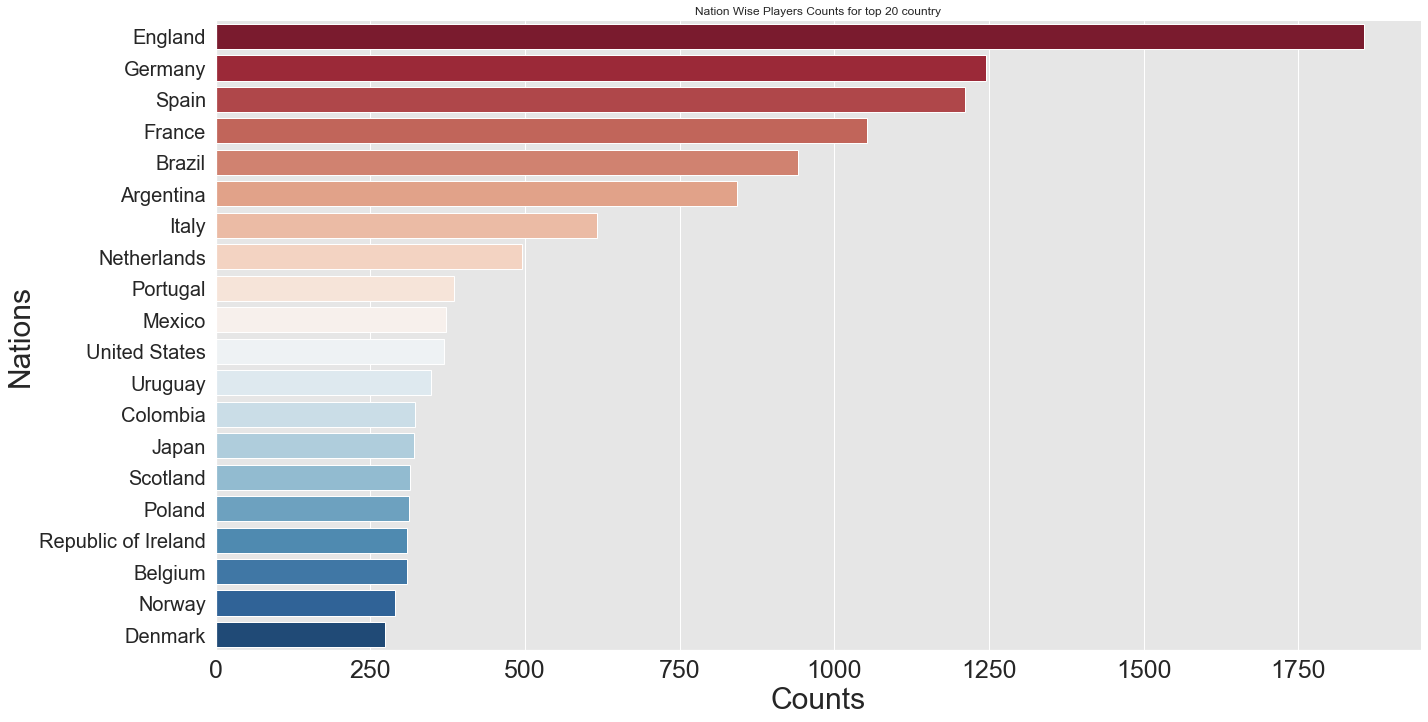

In [378]:
sns.catplot(y="Nations",
            x="Counts",data=counts_Nationality_top20,
            palette="RdBu",height=10,kind="bar",aspect=2)
plt.title("Nation Wise Players Counts for top 20 country");

### Wage and overall rating in different position types

In [379]:
avgwageoverall = df.groupby("class_with_name", as_index=False)["Wage"].mean()
avgwageoverall.sort_values(by="Wage",inplace=True,ascending=False)
avgwageoverall.head()

class_with_name          Wage
3      Midfielder  10709.110519
1        Forwards  10519.395973
0            Back   9717.410109
2      Goalkeeper   7960.574190

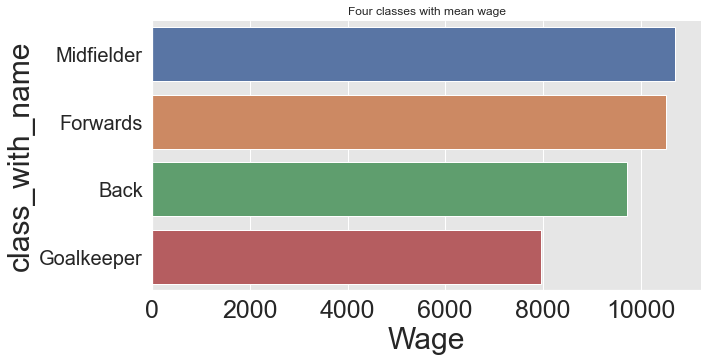

In [380]:
sns.catplot(y="class_with_name",
            x="Wage",data=avgwageoverall,kind="bar",aspect=2)
plt.title("Four classes with mean wage");

In [381]:
features = ('Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
                   'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
                   'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
                   'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
                   'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
                   'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
                   'GK Reflexes')

In [382]:
df_feature=df.groupby(df['class_with_name'])[features].mean()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [383]:
df_feature

Crossing  Finishing  Heading Accuracy  Short Passing  \
class_with_name                                                          
Back             52.151391  36.128445         61.450521      60.560103   
Forwards         49.017520  67.685763         64.194435      60.146109   
Goalkeeper       14.104724  11.629841         14.248009      27.618885   
Midfielder       59.814710  56.655146         51.942053      67.153470   

                   Volleys  Dribbling      Curve  FK Accuracy  Long Passing  \
class_with_name                                                               
Back             36.249404  54.137472  44.745696    39.224129     54.613195   
Forwards         60.112474  64.490444  53.782403    46.166330     47.323212   
Goalkeeper       11.967447  13.836746  14.755416    14.268071     26.734775   
Midfielder       52.558737  67.007839  58.593534    53.718957     62.289308   

                 Ball Control  ...  Penalties  Composure  Defensive Awareness  \
class_with_name                ...                                              
Back                59.165582  ...  44.000680  59.113033            63.954621   
Forwards            65.699829  ...  64.065634  61.998947            29.011190   
Goalkeeper          20.092772  ...  19.735077  43.306480            14.443140   
Midfielder          68.004756  ...  55.972791  62.757907            48.512117   

                 Standing Tackle  Sliding Tackle  GK Diving  GK Handling  \
class_with_name                                                            
Back                   66.883462       65.222603  10.449440    10.504072   
Forwards               26.539651       23.738851  10.303091    10.525714   
Goalkeeper             14.047240       13.886986  66.656502    64.409326   
Midfielder             49.663469       46.956199  10.356690    10.477786   

                 GK Kicking  GK Positioning  GK Reflexes  
class_with_name                                           
Back              10.519179       10.465728    10.413641  
Forwards          10.744538       10.419832    10.533782  
Goalkeeper        63.027570       64.936023    67.649163  
Midfielder        10.605130       10.439325    10.408733  

[4 rows x 34 columns]

In [384]:
for i, features in df_feature.iterrows():
    top_features = dict(features.nlargest(8))
    print(top_features)

{'Strength': 70.17912238601302, 'Jumping': 69.21438356164384, 'Stamina': 67.26322115384616, 'Standing Tackle': 66.8834618680377, 'Aggression': 65.94249146757679, 'Sprint Speed': 65.51315563198624, 'Sliding Tackle': 65.2226033270451, 'Acceleration': 64.38741210770023}
{'Strength': 69.74161533196441, 'Sprint Speed': 69.62453023573624, 'Acceleration': 68.71788756388416, 'Jumping': 68.07340389211335, 'Shot Power': 67.79011925042589, 'Finishing': 67.68576329331046, 'Agility': 66.78277153558052, 'Positioning': 66.7501704158146}
{'GK Reflexes': 67.64916330063474, 'GK Diving': 66.65650172612197, 'GK Positioning': 64.93602305475504, 'GK Handling': 64.40932642487047, 'GK Kicking': 63.027570361861, 'Strength': 60.93621867881549, 'Reactions': 60.36264367816092, 'Jumping': 58.55251141552512}
{'Balance': 71.67303255575493, 'Agility': 71.42982117586517, 'Acceleration': 70.49652599073598, 'Sprint Speed': 69.3224395265054, 'Ball Control': 68.0047557840617, 'Short Passing': 67.153470437018, 'Stamina': 6

In [253]:
defence=pd.DataFrame({'Strength': 70.17912238601302, 'Jumping': 69.21438356164384, 'Stamina': 67.26322115384616, 'Standing Tackle': 66.8834618680377, 'Aggression': 65.94249146757679, 'Sprint Speed': 65.51315563198624, 'Sliding Tackle': 65.2226033270451, 'Acceleration': 64.38741210770023},index=['Defense']).T

In [255]:
defence.to_csv('defence.csv')

In [256]:
forwards=pd.DataFrame({'Strength': 69.74161533196441, 'Sprint Speed': 69.62453023573624, 'Acceleration': 68.71788756388416, 'Jumping': 68.07340389211335, 'Shot Power': 67.79011925042589, 'Finishing': 67.68576329331046, 'Agility': 66.78277153558052, 'Positioning': 66.7501704158146},index=['Forwards']).T
forwards.to_csv('forwards.csv')

In [257]:
GK=pd.DataFrame({'GK Reflexes': 67.64916330063474, 'GK Diving': 66.65650172612197, 'GK Positioning': 64.93602305475504, 'GK Handling': 64.40932642487047, 'GK Kicking': 63.027570361861, 'Strength': 60.93621867881549, 'Reactions': 60.36264367816092, 'Jumping': 58.55251141552512},index=['GK']).T
GK.to_csv('goalkeeper.csv')

In [258]:
Midfielder=pd.DataFrame({'Balance': 71.67303255575493, 'Agility': 71.42982117586517, 'Acceleration': 70.49652599073598, 'Sprint Speed': 69.3224395265054, 'Ball Control': 68.0047557840617, 'Short Passing': 67.153470437018, 'Stamina': 67.11009292720702, 'Dribbling': 67.00783860190182},index=['Midfielder']).T
Midfielder.to_csv('Midfielder.csv')

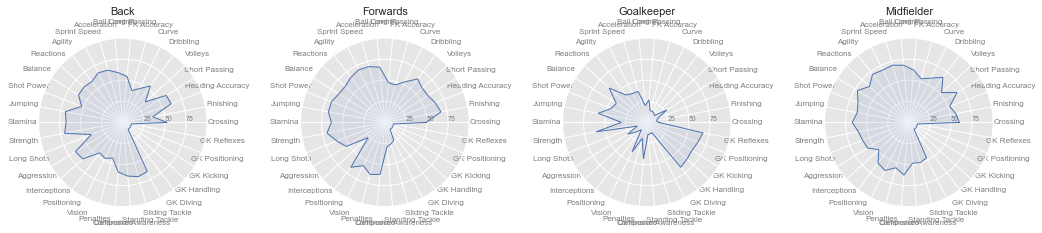

In [385]:
from math import pi
idx = 1
plt.figure(figsize=(18,45))
for i, features in df_feature.iterrows():
    top_features = dict(features)
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = list(top_features.values())
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(10, 4, idx, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    

    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(i, size=11, y=1.1)
    
    idx += 1

plt.savefig('prediction.png',dpi=600)

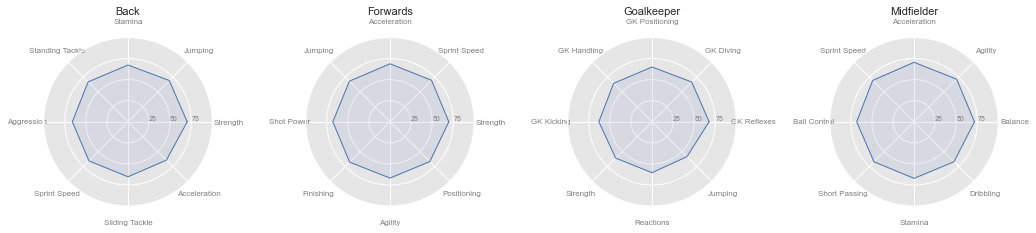

In [386]:
from math import pi
idx = 1
plt.figure(figsize=(18,45))
for i, features in df_feature.iterrows():
    top_features = dict(features.nlargest(8))
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = list(top_features.values())
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(10, 4, idx, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    

    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(i, size=11, y=1.1)
    
    idx += 1

plt.savefig('prediction1.png',dpi=600)

### Select features
Keep the same with Mingyu

In [179]:
features_choose = ['Jumping', 'Stamina', 'Strength', 'Acceleration', 'GK Reflexes'
            ,'Agility', 'Sliding Tackle', 'Volleys', 'Positioning',
            'Heading Accuracy', 'Aggression', 'Shot Power', 'Balance', 'Ball Control', 
            'Penalties', 'Vision', 'Long Passing']
fifa = df.dropna(subset=features_choose)

In [180]:
fifa.groupby(['class_with_name'])['ID'].count()

class_with_name
Defence-men    5722
Forwards       2828
Goalkeeper     1715
Mid-fielder    7565
Name: ID, dtype: int64

### Model Building

In [181]:
from sklearn.model_selection import train_test_split
y = fifa['class_with_name']
X = fifa[features_choose]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [182]:
# logistic 
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg.fit(X_train,y_train)
y_pred=lg.predict(X_test)
lg.score(X_test,y_test)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8869882220975883

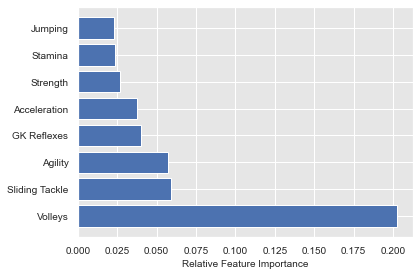

In [368]:
feature_importance = pd.Series(abs(lg.coef_[0])).nlargest(8)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance, align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Relative Feature Importance',fontsize=10)
plt.tick_params(labelsize=10)

plt.tight_layout()   
plt.show()

In [183]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 Defence-men       0.88      0.90      0.89      1144
    Forwards       0.89      0.84      0.86       566
  Goalkeeper       1.00      1.00      1.00       343
 Mid-fielder       0.86      0.87      0.87      1513

    accuracy                           0.89      3566
   macro avg       0.91      0.90      0.91      3566
weighted avg       0.89      0.89      0.89      3566



In [264]:
from sklearn.svm import SVC
svm=SVC(kernel="linear")
svm.fit(X_train,y_train)
y_pred2 = svm.predict(X_test)
svm.score(X_test,y_test)

0.8869882220975883

In [263]:
# svm  #linear的更低 这里不选取linear
from sklearn.svm import SVC
svm2=SVC()
svm2.fit(X_train,y_train)
y_pred2 = svm2.predict(X_test)
svm2.score(X_test,y_test)

0.8990465507571509

In [185]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

 Defence-men       0.90      0.92      0.91      1144
    Forwards       0.91      0.82      0.86       566
  Goalkeeper       1.00      1.00      1.00       343
 Mid-fielder       0.87      0.89      0.88      1513

    accuracy                           0.90      3566
   macro avg       0.92      0.91      0.91      3566
weighted avg       0.90      0.90      0.90      3566



In [199]:
from sklearn import multiclass
model=sklearn.multiclass.OneVsRestClassifier(SVC()).fit(X_train,y_train)
model.score(X_test,y_test)

0.8982052720134605

In [211]:
from sklearn import multiclass
model1=sklearn.multiclass.OneVsOneClassifier(SVC()).fit(X_train,y_train)
model1.score(X_test,y_test)

0.9004486819966349

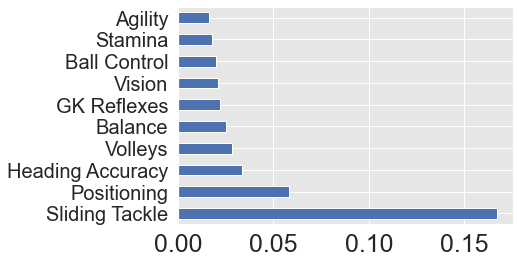

In [285]:
#只有linear的才能做feature importance
a=pd.Series(abs(svm.coef_[0]), index=features_choose)
a.nlargest(10).plot(kind='barh')
plt.show()

### XGBoost for optimization for all 4 Positions

In [ ]:
features_choose_gk=['GK Reflexes', 'GK Diving', 'GK Positioning', 'GK Handling', 'GK Kicking', 'Strength', 'Reactions', 'Jumping']
y_gk = df_gk['Value']
X_gk = df_gk[features_choose_gk]
xg_gk = xgb.XGBRegressor(objective ='reg:linear')
xg_gk.fit(X_gk,y_gk)
feat_importances1 = pd.Series(xg_gk.feature_importances_, index=X_gk.columns)
feat_importances1.plot(kind='barh')
plt.show()
feat_importances1.to_csv('para_gk.csv')

In [307]:
features_choose_gk=['GK Reflexes', 'GK Diving', 'GK Positioning', 'GK Handling', 'GK Kicking', 'Strength', 'Reactions', 'Jumping']
y_gk = df_gk['Value']
X_gk = df_gk[features_choose_gk]

In [308]:
features_choose_mid=['Balance', 'Agility', 'Acceleration', 'Sprint Speed', 'Ball Control', 'Short Passing', 'Stamina', 'Dribbling']
y_mid = df_mid['Value']
X_mid = df_mid[features_choose_mid]

In [309]:
features_choose_for=['Strength', 'Sprint Speed', 'Acceleration', 'Jumping', 'Shot Power', 'Finishing', 'Agility', 'Positioning']
y_for = df_for['Value']
X_for = df_for[features_choose_for]

In [310]:
features_choose_def=['Strength', 'Jumping', 'Stamina', 'Standing Tackle', 'Aggression', 'Sprint Speed', 'Sliding Tackle', 'Acceleration']
y_def = df_def['Value']
X_def = df_def[features_choose_def]

In [316]:
xg_gk = xgb.XGBRegressor(objective ='reg:linear')
xg_gk.fit(X_gk,y_gk)

[18:15:06] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:07] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

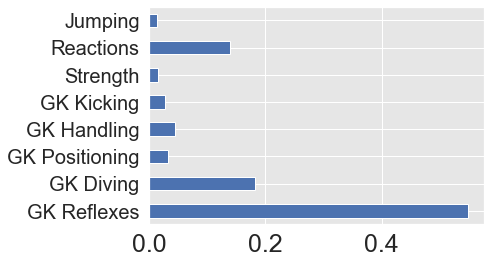

In [320]:
feat_importances1 = pd.Series(xg_gk.feature_importances_, index=X_gk.columns)
feat_importances1.plot(kind='barh')
plt.show()

In [332]:
feat_importances1
feat_importances1.to_csv('para_gk.csv')

In [326]:
xg_for = xgb.XGBRegressor(objective ='reg:linear')
xg_for.fit(X_for,y_for)
feat_importances2 = pd.Series(xg_for.feature_importances_, index=X_for.columns)
feat_importances2

[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


Strength        0.014168
Sprint Speed    0.043102
Acceleration    0.023909
Jumping         0.065959
Shot Power      0.040538
Finishing       0.587023
Agility         0.075685
Positioning     0.149616
dtype: float32

In [327]:
xg_mid = xgb.XGBRegressor(objective ='reg:linear')
xg_mid.fit(X_mid,y_mid)
feat_importances3 = pd.Series(xg_mid.feature_importances_, index=X_mid.columns)
feat_importances3

[18:20:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


Balance          0.018916
Agility          0.027673
Acceleration     0.027785
Sprint Speed     0.042197
Ball Control     0.620235
Short Passing    0.055095
Stamina          0.111545
Dribbling        0.096554
dtype: float32

In [331]:
xg_def = xgb.XGBRegressor(objective ='reg:linear')
xg_def.fit(X_def,y_def)
feat_importances4 = pd.Series(xg_def.feature_importances_, index=X_def.columns)
feat_importances4

[18:20:44] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


Strength           0.017751
Jumping            0.025091
Stamina            0.044128
Standing Tackle    0.240001
Aggression         0.028005
Sprint Speed       0.065580
Sliding Tackle     0.471076
Acceleration       0.108368
dtype: float32

In [333]:
feat_importances2.to_csv('para_for.csv')
feat_importances3.to_csv('para_mid.csv')
feat_importances4.to_csv('para_def.csv')

### Candidates

In [207]:
candidates=pd.read_csv('candidates.csv',encoding='gbk')

In [208]:
candidates

General_position  index      ID                   Name  Age  Nationality  \
0                Def   2868  259074         Albian Hajdari   17  Switzerland   
1                Def    104  258315  Bright Akwo Arrey-Mbi   17      Germany   
2                Def    430  258490             Chadi Riad   17      Morocco   
3                Def  11298  258428           Luca Floric?   17      Romania   
4                Def   6842  257090        Isma?l Doukouré   16       France   
..               ...    ...     ...                    ...  ...          ...   
195              Mid   6489  254556           Kélian Nsona   18       France   
196              Mid  15865  247532        Reegan Mimnaugh   18     Scotland   
197              Mid   7833  258108       Facundo Trinidad   18      Uruguay   
198              Mid  10087  258604      Norbert Wojtuszek   18       Poland   
199              Mid   7831  252530        Fabio Solimando   18  Switzerland   

     Overall  Potential                    Club   Value  ...  \
0         53         79           FC Basel 1893  120000  ...   
1         60         86       Bayern München II  425000  ...   
2         59         84          CE Sabadell FC  325000  ...   
3         51         75         FC Hermannstadt   70000  ...   
4         51         75         Valenciennes FC   80000  ...   
..       ...        ...                     ...     ...  ...   
195       56         77     Stade Malherbe Caen  200000  ...   
196       51         72  Hamilton Academical FC   80000  ...   
197       57         78   Liverpool Fútbol Club  230000  ...   
198       52         73           Górnik Zabrze  110000  ...   
199       54         75           FC St. Gallen  150000  ...   

     Defensive Awareness  Standing Tackle Sliding Tackle GK Diving  \
0                   47.0               58             52        12   
1                   55.0               64             61        13   
2                   51.0               67             65        10   
3                   36.0               50             52        12   
4                   47.0               58             57         9   
..                   ...              ...            ...       ...   
195                 20.0               30             23        10   
196                 40.0               45             51         6   
197                 39.0               35             49         5   
198                 22.0               31             41        14   
199                 34.0               37             41         5   

    GK Handling GK Kicking GK Positioning GK Reflexes General_position.1  \
0             9          9             11           5                Def   
1             9          8             12           8                Def   
2            12          9              8          10                Def   
3            10          9             10          12                Def   
4            14         14             11          12                Def   
..          ...        ...            ...         ...                ...   
195          13         11              6          13                Mid   
196          15          7              9          12                Mid   
197           7          9             10           9                Mid   
198           6          7             11          14                Mid   
199           9         15              5          15                Mid   

     rate_gap  
0          26  
1          26  
2          25  
3          24  
4          24  
..        ...  
195        21  
196        21  
197        21  
198        21  
199        21  

[200 rows x 59 columns]

In [280]:
candidates_feature=candidates.groupby(candidates['General_position'])[features].mean()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


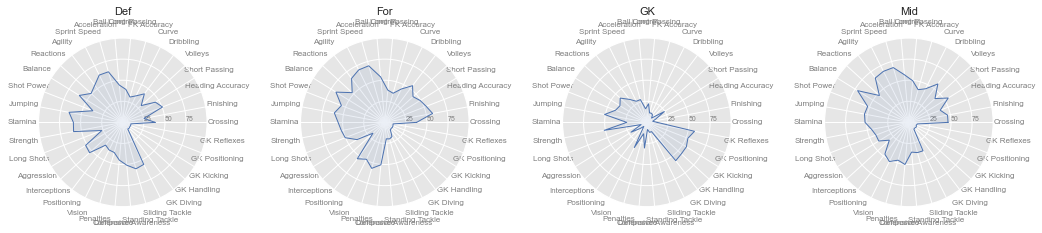

In [281]:
from math import pi
idx = 1
plt.figure(figsize=(18,45))
for i,features in candidates_feature.iterrows():
    top_features = dict(features)
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = list(top_features.values())
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(10, 4, idx, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    

    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(i, size=11, y=1.1)
    
    idx += 1

plt.savefig('prediction.png',dpi=600)

In [216]:
df_candidates= candidates.dropna(subset=features_choose)

In [219]:
X_candidates = df_candidates[features_choose]
X_candidates

Jumping  Stamina  Strength  Acceleration  GK Reflexes  Agility  \
0         66       56        68            58            5       45   
1         78       62        71            66            8       68   
2         65       60        56            59           10       56   
3         35       54        37            61           12       62   
4         67       55        51            61           12       45   
..       ...      ...       ...           ...          ...      ...   
195       35       36        66            86           13       56   
196       64       57        50            63           12       55   
197       53       60        57            68            9       67   
198       47       51        58            61           14       54   
199       42       50        33            67           15       85   

     Sliding Tackle  Volleys  Positioning  Heading Accuracy  Aggression  \
0                52       28           28                53          51   
1                61       30           35                59          63   
2                65       34           28                62          54   
3                52       24           46                32          31   
4                57       23           28                48          49   
..              ...      ...          ...               ...         ...   
195              23       41           47                33          34   
196              51       40           51                48          61   
197              49       37           49                43          43   
198              41       39           45                37          32   
199              41       39           45                36          34   

     Shot Power  Balance  Ball Control  Penalties  Vision  Long Passing  
0            38       50          28.0         36      27            25  
1            38       68          54.0         33      44            44  
2            42       65          50.0         46      35            49  
3            23       69          44.0         37      35            41  
4            37       62          30.0         37      29            27  
..          ...      ...           ...        ...     ...           ...  
195          70       55          61.0         55      48            33  
196          53       52          54.0         42      51            50  
197          43       75          55.0         46      50            63  
198          56       60          51.0         55      53            46  
199          50       90          57.0         55      51            47  

[199 rows x 17 columns]

In [220]:
y_pred = model1.predict(X_candidates)

In [221]:
y_pred

array(['Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Mid-fielder', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Mid-fielder', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Defence-men', 'Defence-men',
       'Defence-men', 'Defence-men', 'Forwards', 'Forwards', 'Forwards',
       'Forwards', 'Mid-fielder', 'Forwards', 'Mid-fielder', 'Forwards',
       'Forwards', 'Forwards', 'Forwards', 'Mid-fi

In [222]:
df_candidates['prediction']=y_pred

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [223]:
df_candidates

General_position  index      ID                   Name  Age  Nationality  \
0                Def   2868  259074         Albian Hajdari   17  Switzerland   
1                Def    104  258315  Bright Akwo Arrey-Mbi   17      Germany   
2                Def    430  258490             Chadi Riad   17      Morocco   
3                Def  11298  258428           Luca Floric?   17      Romania   
4                Def   6842  257090        Isma?l Doukouré   16       France   
..               ...    ...     ...                    ...  ...          ...   
195              Mid   6489  254556           Kélian Nsona   18       France   
196              Mid  15865  247532        Reegan Mimnaugh   18     Scotland   
197              Mid   7833  258108       Facundo Trinidad   18      Uruguay   
198              Mid  10087  258604      Norbert Wojtuszek   18       Poland   
199              Mid   7831  252530        Fabio Solimando   18  Switzerland   

     Overall  Potential                    Club   Value  ...  Standing Tackle  \
0         53         79           FC Basel 1893  120000  ...               58   
1         60         86       Bayern München II  425000  ...               64   
2         59         84          CE Sabadell FC  325000  ...               67   
3         51         75         FC Hermannstadt   70000  ...               50   
4         51         75         Valenciennes FC   80000  ...               58   
..       ...        ...                     ...     ...  ...              ...   
195       56         77     Stade Malherbe Caen  200000  ...               30   
196       51         72  Hamilton Academical FC   80000  ...               45   
197       57         78   Liverpool Fútbol Club  230000  ...               35   
198       52         73           Górnik Zabrze  110000  ...               31   
199       54         75           FC St. Gallen  150000  ...               37   

     Sliding Tackle GK Diving GK Handling GK Kicking GK Positioning  \
0                52        12           9          9             11   
1                61        13           9          8             12   
2                65        10          12          9              8   
3                52        12          10          9             10   
4                57         9          14         14             11   
..              ...       ...         ...        ...            ...   
195              23        10          13         11              6   
196              51         6          15          7              9   
197              49         5           7          9             10   
198              41        14           6          7             11   
199              41         5           9         15              5   

    GK Reflexes General_position.1 rate_gap   prediction  
0             5                Def       26  Defence-men  
1             8                Def       26  Defence-men  
2            10                Def       25  Defence-men  
3            12                Def       24  Defence-men  
4            12                Def       24  Defence-men  
..          ...                ...      ...          ...  
195          13                Mid       21  Mid-fielder  
196          12                Mid       21  Mid-fielder  
197           9                Mid       21  Mid-fielder  
198          14                Mid       21  Mid-fielder  
199          15                Mid       21  Mid-fielder  

[199 rows x 60 columns]

In [224]:
df_candidates.to_csv('candidates_prediction.csv')

# Regression Data Pre-processing

In [ ]:
# code used to combine file
# path = 'data/'
# filelist = os.listdir(path)
# field_dict = {'A1':'Goalkeeper', 
#               'A2':'Back', 'A3':'Back', 'A4':'Back', 
#               'A5':'Midfield', '6':'Midfield', '7':'Midfield', '8':'Midfield',
#               '9':'Forward','10':'Forward', '11':'Forward'}

# df = pd.DataFrame()
# for i in filelist:
#     area = [i.split('_') if '_' in i else i.split("-")][0][0]
#     area = [area.split('.')[0] if 'xlsx' in area else area][0]
#     subset = pd.read_excel(path+i)
#     subset['Playing Area'] = field_dict[area]
#     df = pd.concat([df, subset])
        
# df.head()
# df = df.drop_duplicates(keep='first')
# df.to_csv('Positions_500ea.csv')

In [2]:
# Wyscout dataset
df = pd.read_csv('Positions_500ea.csv')
# FIFA dataset
data = fifa.copy()
# Selected candidates
candidates = pd.read_csv('Candidates_wyscout.csv')
df.head()

Player             Team           Position  Age  Market value  \
0         K. De Bruyne  Manchester City   RCMF3, AMF, RDMF   29     120000000   
1       Bernardo Silva  Manchester City  RCMF3, RWF, LCMF3   26      80000000   
2          F. Valverde      Real Madrid   RCMF3, RCMF, DMF   22      70000000   
3             N. Kanté          Chelsea   DMF, RCMF, RCMF3   29      70000000   
4  S. Milinković-Savić            Lazio              RCMF3   25      65000000   

  Contract expires  Matches played  Minutes played  Goals     xG  ...  \
0       2023-06-30              48            3982     17  13.27  ...   
1       2025-06-30              50            3193      4   5.62  ...   
2       2025-06-30              47            3308      4   3.08  ...   
3       2023-06-30              37            3180      2   2.20  ...   
4       2024-06-30              42            3585     10   9.75  ...   

   Back passes received as GK per 90  Exits per 90  Aerial duels per 90.1  \
0                               0.43           NaN                    NaN   
1                               0.45           NaN                    NaN   
2                               0.35           NaN                    NaN   
3                               0.54           NaN                    NaN   
4                               0.40           NaN                    NaN   

   Free kicks per 90 Direct free kicks per 90 Direct free kicks on target, %  \
0               1.27                     0.45                           55.0   
1               0.03                     0.00                            0.0   
2               0.00                     0.00                            0.0   
3               0.00                     0.00                            0.0   
4               0.23                     0.20                           62.5   

  Corners per 90  Penalties taken  Penalty conversion, % Playing Area  
0           4.14                6                 83.333     Midfield  
1           0.76                0                  0.000     Midfield  
2           0.03                0                  0.000     Midfield  
3           0.00                0                  0.000     Midfield  
4           0.03                0                  0.000     Midfield  

[5 rows x 115 columns]

In [3]:
## Removing selected candidates from the training data set
c = candidates[['Player', 'Age', 'Team']]
c['in_200'] = True
check = df.join(c.set_index(['Player', 'Age', 'Team']), on=['Player', 'Age', 'Team'])
print(f"{df.shape[0]} candidates")
df = check[check['in_200']!=True].drop(['in_200'],axis=1)
print(f"{df.shape[0]} candidates remaining")

8114
8093


In [4]:
# Drop columns that have > 10% Missing values
drop_col = []

for col in df.columns:
    null_count = df[col].isnull().sum()
#     if null_count>0:
#         print(col, ": ", null_count)
        
    if null_count/df.shape[0] > 0.1:
        drop_col.append(col)
        print(f"{col} has {null_count} null values ({null_count/df.shape[0]} %)")

Conceded goals per 90 7599 0.938959594711479
Shots against per 90 7599 0.938959594711479
Prevented goals 7573 0.9357469418015569
Prevented goals per 90 7599 0.938959594711479
Exits per 90 7599 0.938959594711479
Aerial duels per 90.1 7599 0.938959594711479
Free kicks per 90 852 0.10527616458667985
Direct free kicks per 90 852 0.10527616458667985
Direct free kicks on target, % 852 0.10527616458667985


In [5]:
# Drop Player where Position is empty
df = df[df['Position'].notna()]

In [6]:
## Filling in Missing Values for Preferred Foot using FIFA data
print(f"{df['Foot'].isnull().sum()} null values")
df.loc[df['Foot'].isna(), 'Foot'] = df.loc[df['Foot'].isna()].agg(lambda x:data.loc[(data['Name'].str.contains(x['Player'].split('.')[-1])) & 
                                     (data['Club'].str.contains(x['Team'])), 'Preferred Foot'].values, axis=1)
df['Foot'] = df['Foot'].agg(lambda x: ''.join(x))
df.loc[df['Foot']=='', 'Foot'] = np.nan
print(f"{df['Foot'].isnull().sum()} null values")
df.head()

49 null values
42 null values


Player             Team           Position  Age  Market value  \
0         K. De Bruyne  Manchester City   RCMF3, AMF, RDMF   29     120000000   
1       Bernardo Silva  Manchester City  RCMF3, RWF, LCMF3   26      80000000   
2          F. Valverde      Real Madrid   RCMF3, RCMF, DMF   22      70000000   
3             N. Kanté          Chelsea   DMF, RCMF, RCMF3   29      70000000   
4  S. Milinković-Savić            Lazio              RCMF3   25      65000000   

  Contract expires  Matches played  Minutes played  Goals     xG  ...  \
0       2023-06-30              48            3982     17  13.27  ...   
1       2025-06-30              50            3193      4   5.62  ...   
2       2025-06-30              47            3308      4   3.08  ...   
3       2023-06-30              37            3180      2   2.20  ...   
4       2024-06-30              42            3585     10   9.75  ...   

   Back passes received as GK per 90  Exits per 90  Aerial duels per 90.1  \
0                               0.43           NaN                    NaN   
1                               0.45           NaN                    NaN   
2                               0.35           NaN                    NaN   
3                               0.54           NaN                    NaN   
4                               0.40           NaN                    NaN   

   Free kicks per 90 Direct free kicks per 90 Direct free kicks on target, %  \
0               1.27                     0.45                           55.0   
1               0.03                     0.00                            0.0   
2               0.00                     0.00                            0.0   
3               0.00                     0.00                            0.0   
4               0.23                     0.20                           62.5   

  Corners per 90  Penalties taken  Penalty conversion, % Playing Area  
0           4.14                6                 83.333     Midfield  
1           0.76                0                  0.000     Midfield  
2           0.03                0                  0.000     Midfield  
3           0.00                0                  0.000     Midfield  
4           0.03                0                  0.000     Midfield  

[5 rows x 115 columns]

In [7]:
## Drop columns and remaining columns to be filled with SimpleImputer with mean values
drop_col += ['Team', 'Contract expires']
df = df.drop(drop_col, axis=1)
df = df[df['Foot'].notna()]

for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count>0:
        print(col, ": ", null_count)    

Duels per 90 :  350
Duels won, % :  350
Successful defensive actions per 90 :  350
Defensive duels per 90 :  350
Defensive duels won, % :  350
Aerial duels per 90 :  350
Aerial duels won, % :  350
Sliding tackles per 90 :  350
Shots blocked per 90 :  350
Interceptions per 90 :  350
Fouls per 90 :  350
Yellow cards per 90 :  325
Red cards per 90 :  325
Successful attacking actions per 90 :  350
Goals per 90 :  325
Non-penalty goals per 90 :  350
xG per 90 :  350
Head goals per 90 :  350
Shots per 90 :  350
Shots on target, % :  350
Assists per 90 :  350
Crosses per 90 :  350
Accurate crosses, % :  350
Crosses from left flank per 90 :  350
Accurate crosses from left flank, % :  350
Crosses from right flank per 90 :  350
Accurate crosses from right flank, % :  350
Crosses to goalie box per 90 :  350
Dribbles per 90 :  350
Successful dribbles, % :  350
Offensive duels per 90 :  350
Offensive duels won, % :  350
Touches in box per 90 :  350
Progressive runs per 90 :  350
Accelerations per 9

### Pandas Profiling Code
profile = ProfileReport(df, title='Wyscout Players Data EDA Report', explorative=True, minimal=True)
profile.to_file('Wyscout Players Data EDA.html')

## Regression EDA

In [8]:
def plot_pie_count(data, field="Nationality", percent_limit=0.5, title="Number of players by "):
    
    title += field
    data[field] = data[field].fillna('NA')
    data = data[field].value_counts().to_frame()

    total = data[field].sum()
    data['percentage'] = 100 * data[field]/total    

    percent_limit = percent_limit
    otherdata = data[data['percentage'] < percent_limit] 
    others = otherdata['percentage'].sum()  
    maindata = data[data['percentage'] >= percent_limit]

    data = maindata
    other_label = "Others(<" + str(percent_limit) + "% each)"
    data.loc[other_label] = pd.Series({field:otherdata[field].sum()}) 
    
    labels = data.index.tolist()   
    datavals = data[field].tolist()
    
    trace=go.Pie(
        labels=labels,
        values=datavals
    )

    layout = go.Layout(
        title = title,
        height=500,
        width=800
    )
    
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

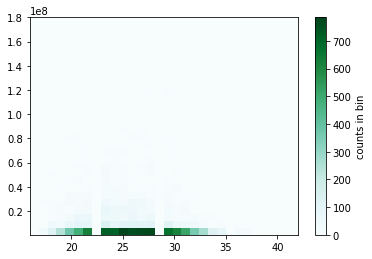

In [15]:
x = df["Age"]
y = df["Market value"]

plt.hist2d(x, y, bins=30, cmap='BuGn')
cb = plt.colorbar()
cb.set_label('counts in bin')

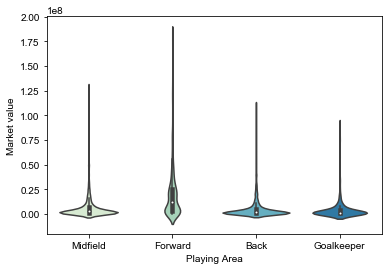

In [16]:
# Violin plot of each playing area market value distribution
# Use a color palette
b = sns.violinplot( x=df["Playing Area"], y=df["Market value"], palette="GnBu")
plt.rcParams['figure.figsize'] = (30, 20)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [17]:
df['age_group'] = pd.cut(df['Age'], bins=range(15, 40, 5))

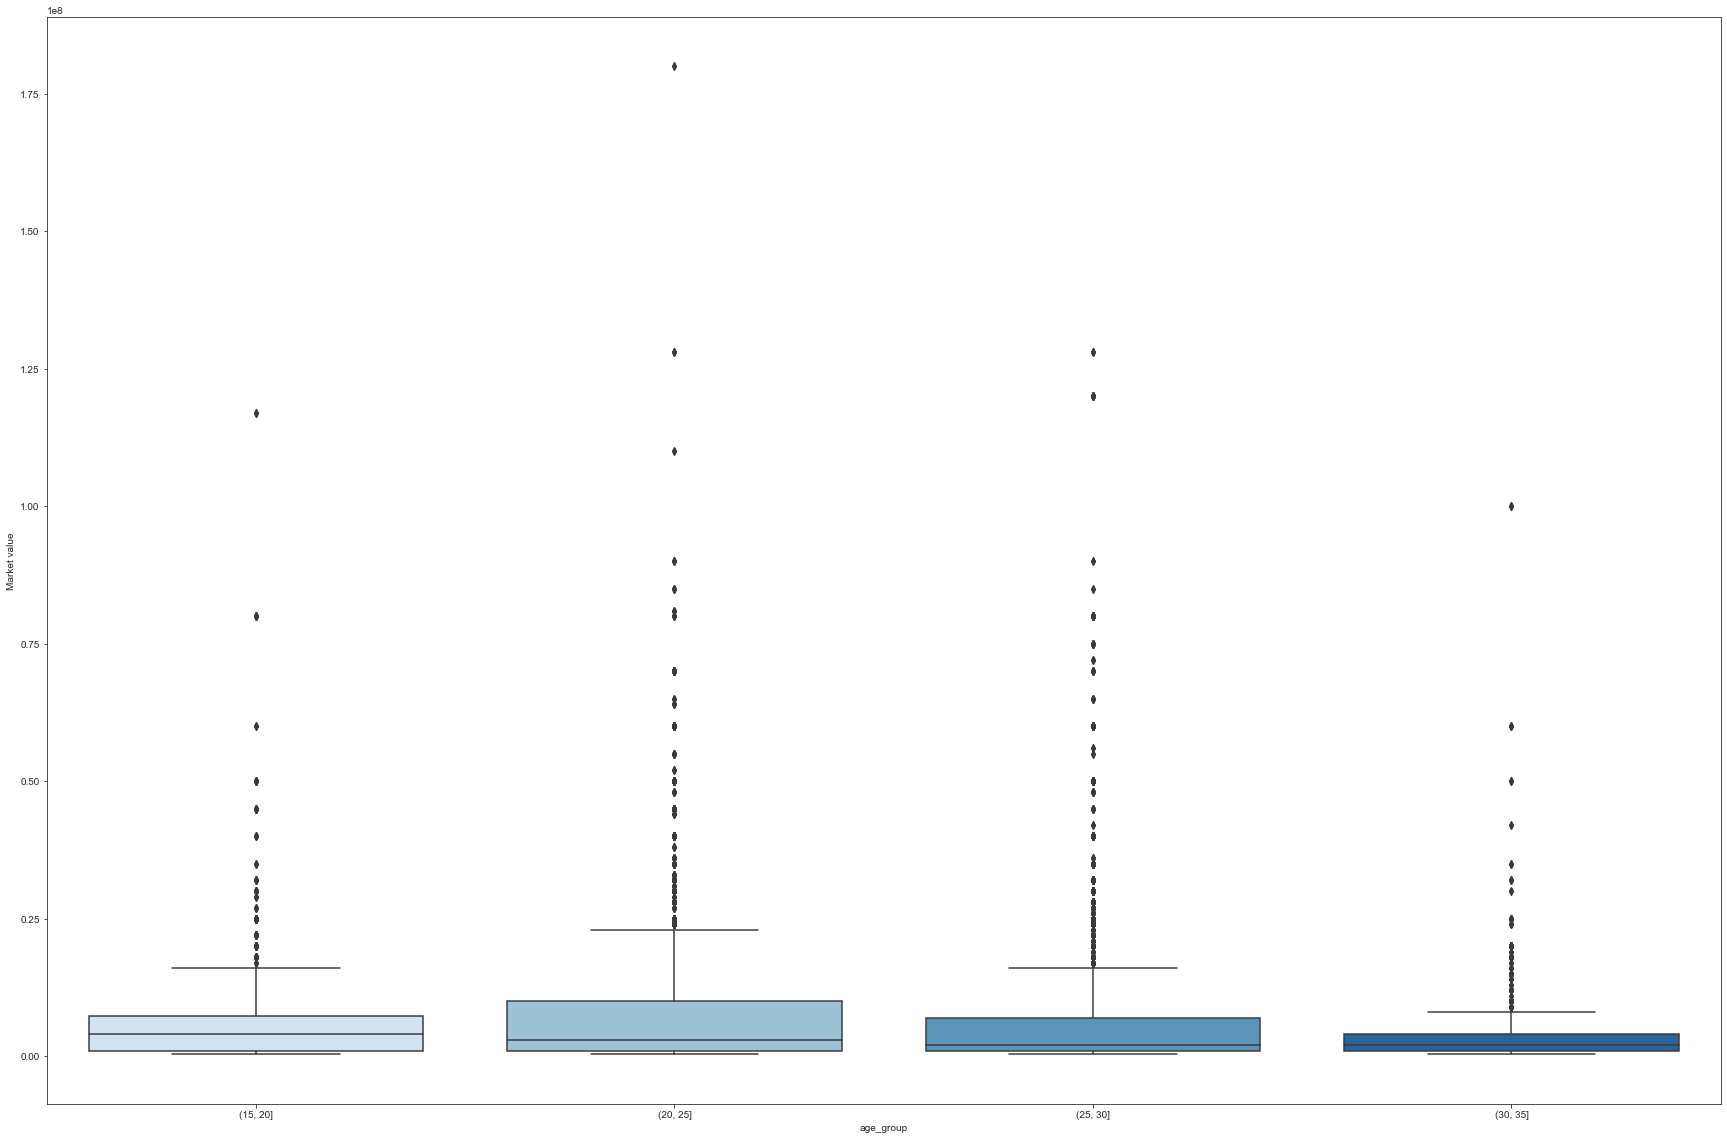

In [18]:
# Box plot of 4 age groups and their market value distribution
# Use a color palette

sns.boxplot( x=df['age_group'], y=df["Market value"], palette="Blues")
plt.rcParams['figure.figsize'] = (30, 20)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

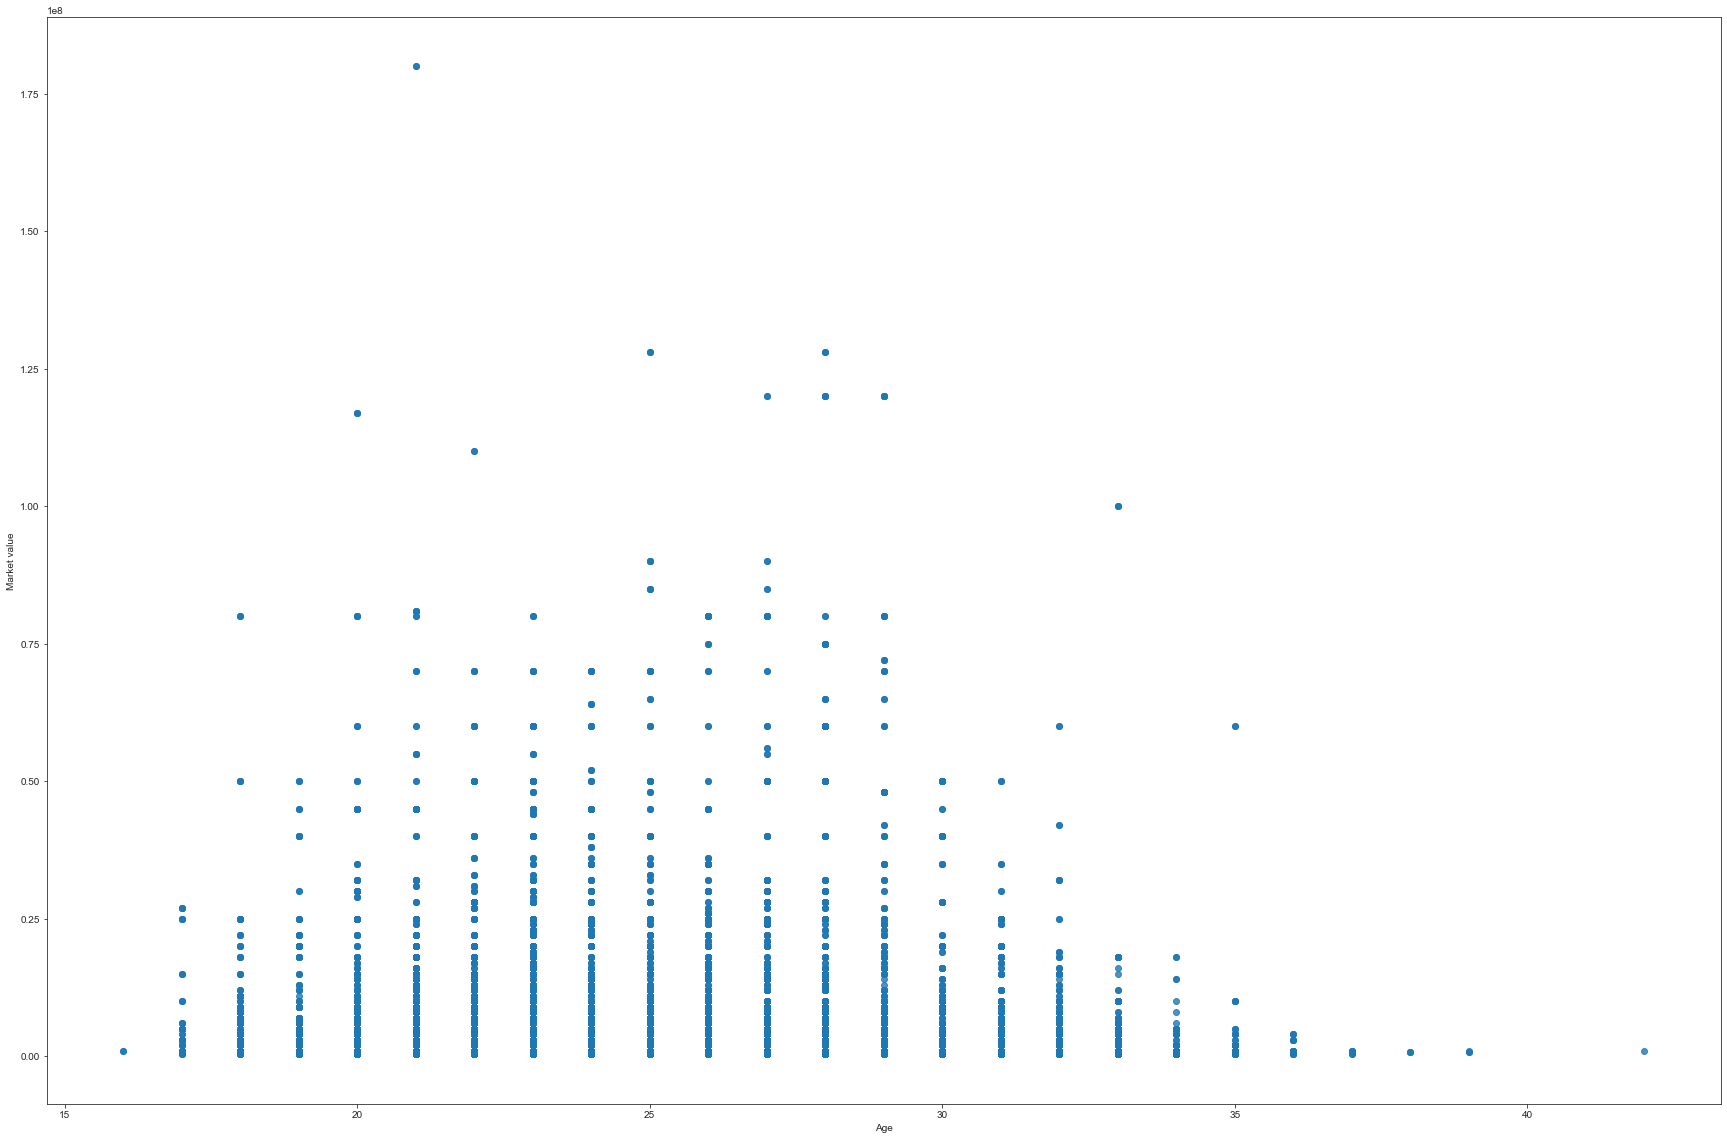

In [19]:
# Scatter plot of age vs market value distribution
# Without regression fit:
sns.regplot(x=df["Age"], y=df["Market value"], fit_reg=False)
#sns.plt.show()


## Columns that Require Categorization or changing

In [8]:
for c in df.columns:
    if df[c].dtype == 'O':
        print(c)

Player
Position
Birth country
Passport country
Foot
On loan
Playing Area


In [9]:
## Converting Binary Categories
df['On loan'] = np.where(df['On loan']=='yes', 1, 0)
## Players who hold same passport as birth country vs different
df['Birth_diff_Passport'] = df['Birth country']!= df['Passport country']
df['Foot'] = np.where(df['Foot']=='right', 1, 0) # Right-1, left-0

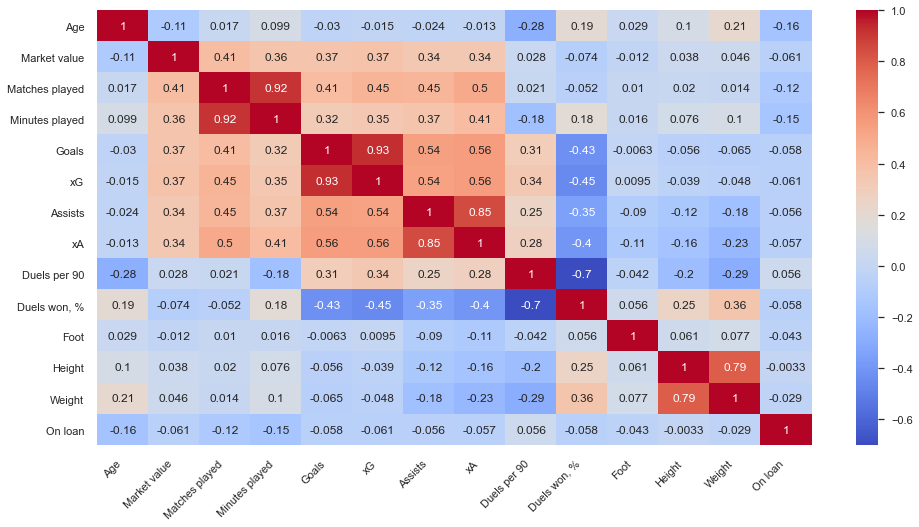

In [10]:
## Heatmap for Player related statistics
info = ['Position',
        'Age',
        'Market value',
        'Matches played',
        'Minutes played',
        'Goals',
        'xG', # Expected Goals
        'Assists',
        'xA', # Expected Assists
        'Duels per 90',
        'Duels won, %',
        'Birth country',
        'Passport country',
        'Foot',
        'Height',
        'Weight',
        'On loan']

sns.set(rc={'figure.figsize':(16,8)})
corr = sns.heatmap(df[info].corr(), annot = True, cmap = 'coolwarm')
corr.set_xticklabels(corr.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()
## Drop list
# drop = ['Goals', 'Assists']

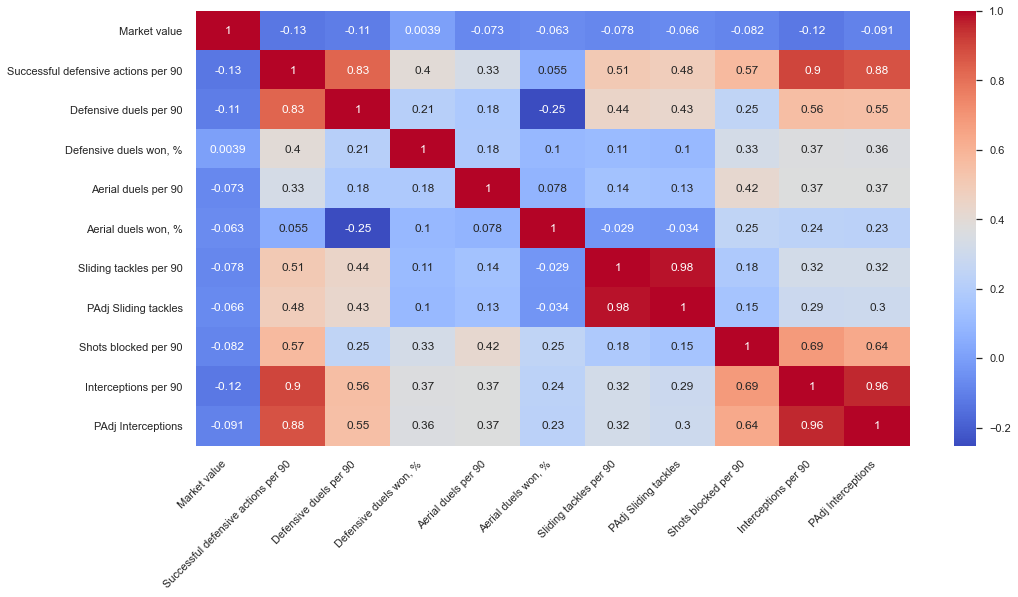

In [11]:
## Heatmap for Match statistics
sel_cols = ['Successful defensive actions per 90',
 'Defensive duels per 90',
 'Defensive duels won, %',
 'Aerial duels per 90',
 'Aerial duels won, %',
 'Sliding tackles per 90',
 'PAdj Sliding tackles',
 'Shots blocked per 90',
 'Interceptions per 90',
 'PAdj Interceptions']

sns.set(rc={'figure.figsize':(16,8)})
corr = sns.heatmap(df[['Market value']+sel_cols].corr(), annot = True, cmap = 'coolwarm')
corr.set_xticklabels(corr.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

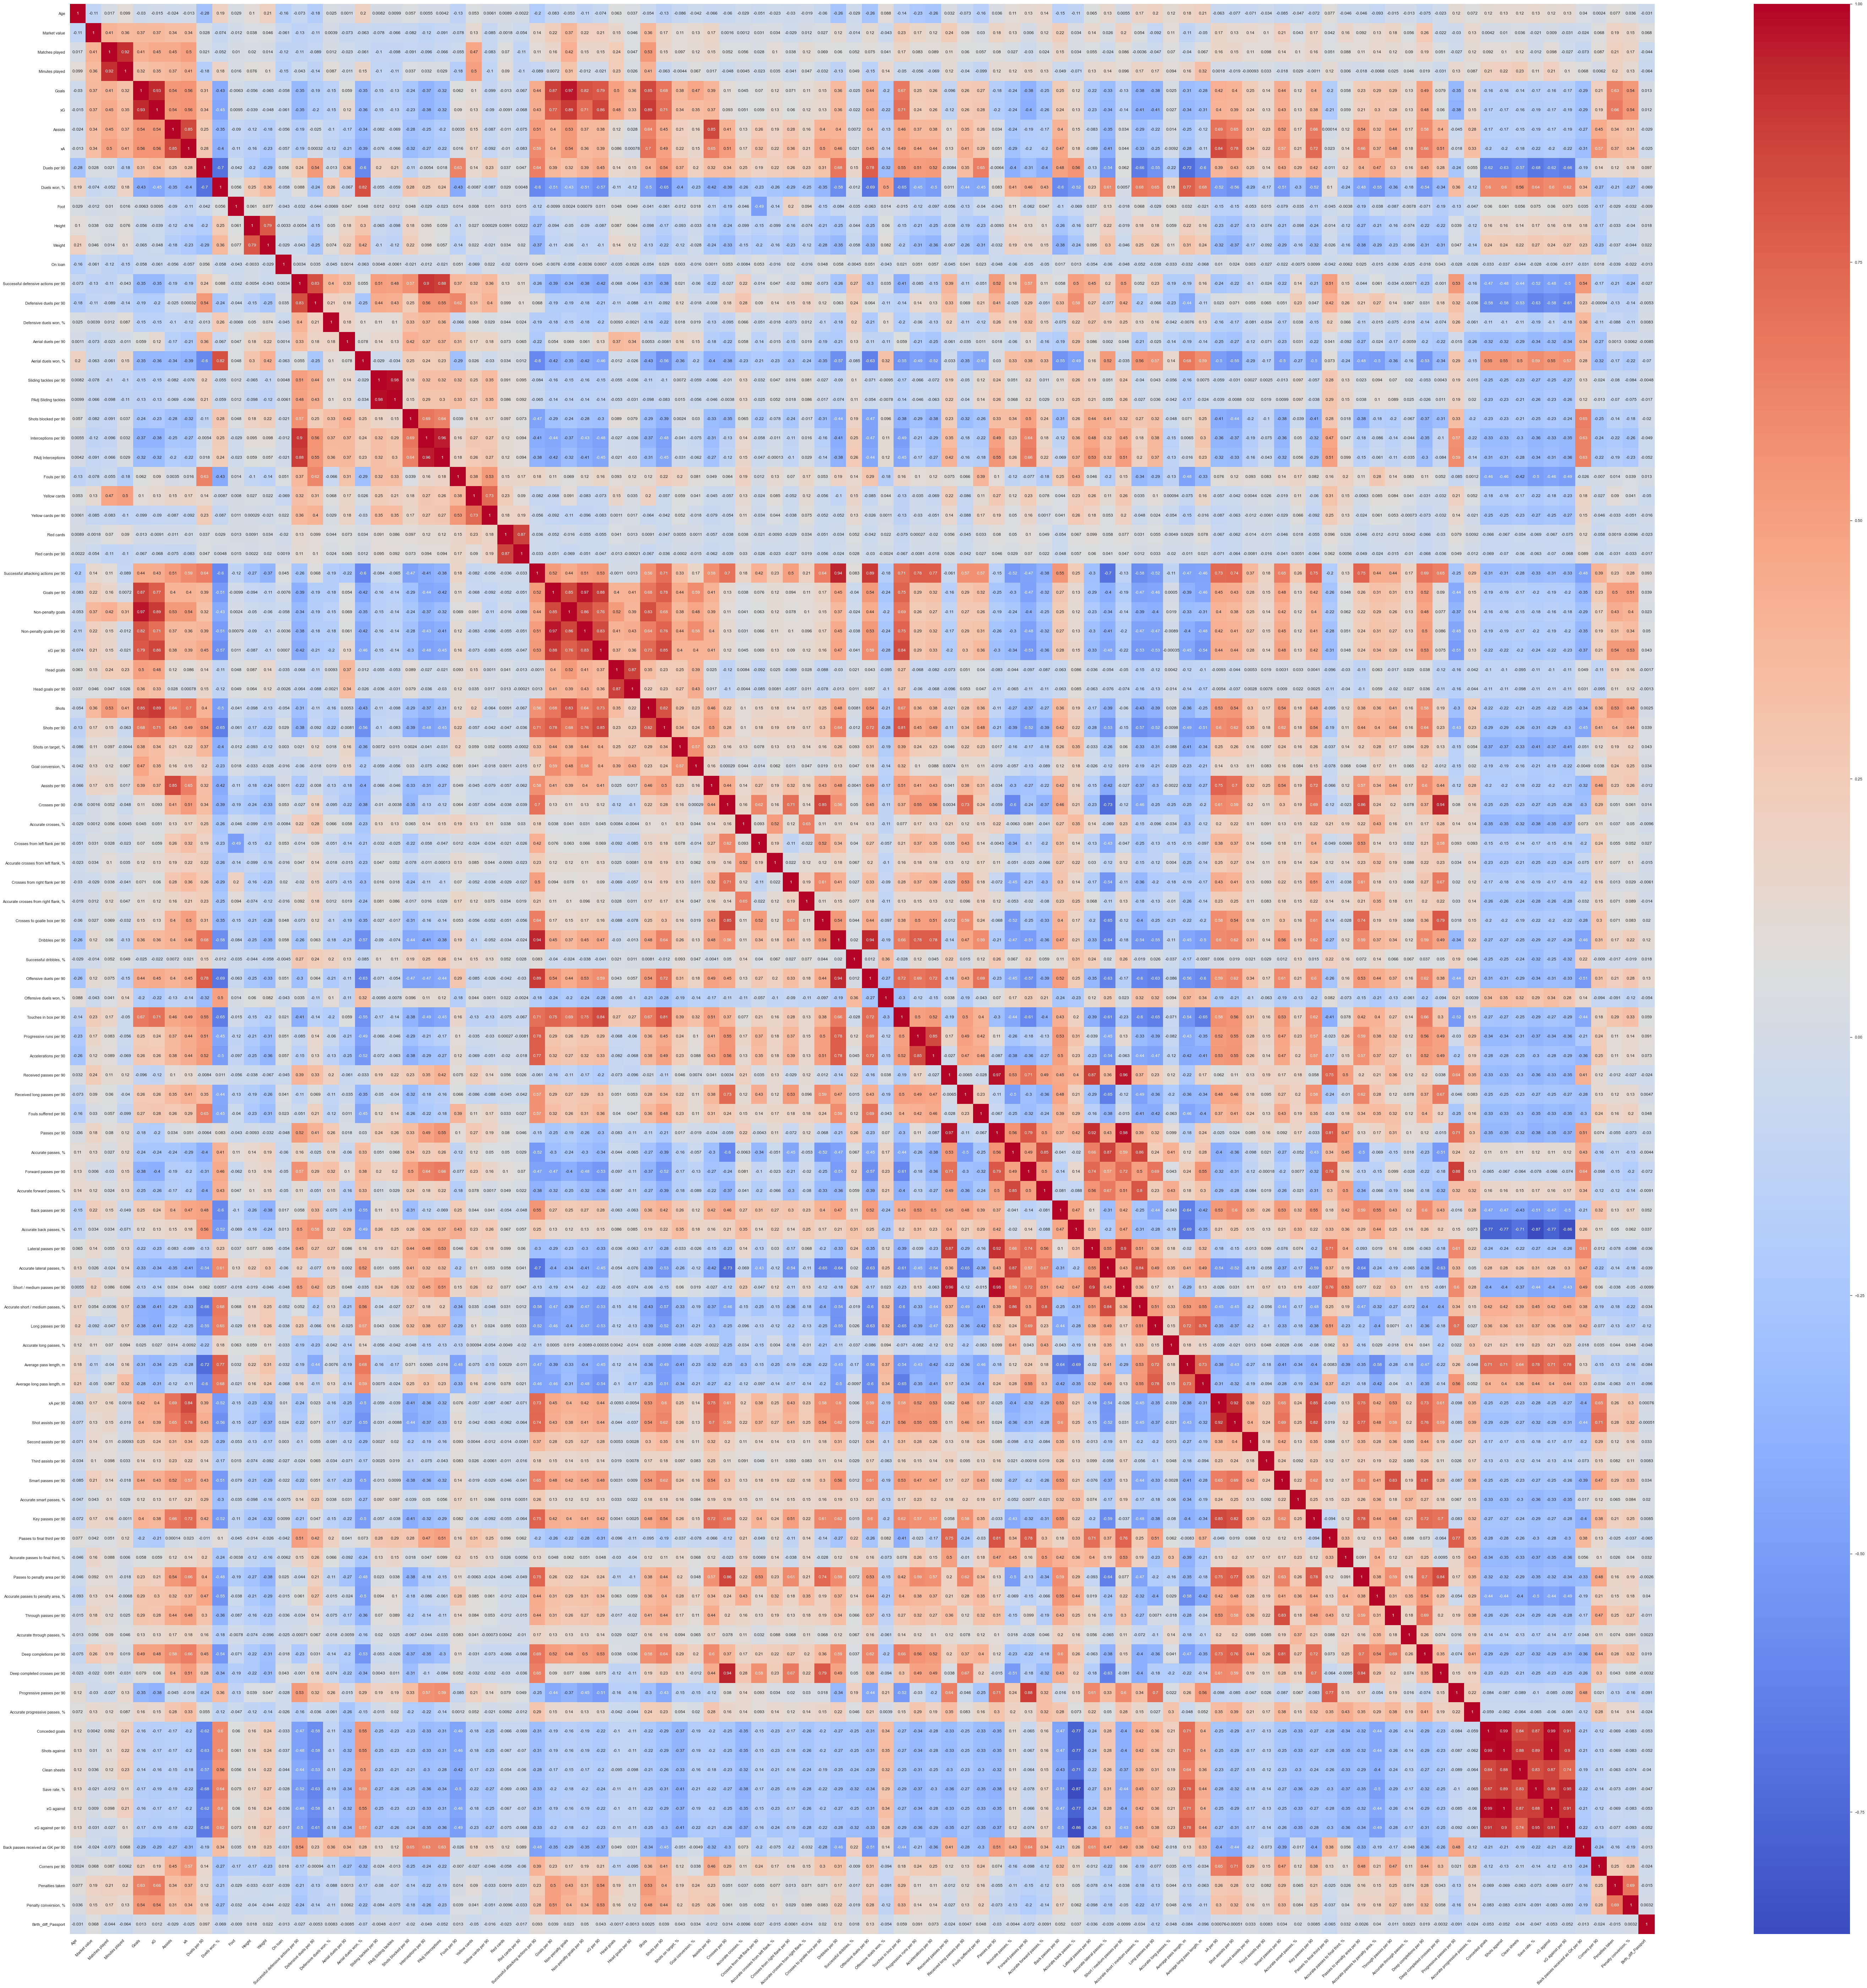

In [12]:
## Heatmap for all statistics
sns.set(rc={'figure.figsize':(100,100)})
corr = sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
corr.set_xticklabels(corr.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Data Imputation

## Splitting Train and Test Set (Important)

In [13]:
df2 = df.copy()
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for area in df2['Playing Area'].unique():
    X = df2[df2['Playing Area']==area].drop(['Player', 'Position', 'Birth country', 'Passport country',
                                             'Market value', 'Playing Area'],axis=1)
    y = np.log10(df2[df2['Playing Area']==area][['Market value']].values)
    X_train[area], X_test[area], y_train[area], y_test[area] = train_test_split(X,y, test_size=0.33, random_state=42)

In [14]:
from collections import Counter
Counter(df2['Playing Area'])

Counter({'Midfield': 3829, 'Forward': 1301, 'Back': 2426, 'Goalkeeper': 494})

## Predicting Market Value of Players by Playing Area (GK, Back, Midfield and Forward)

### Testing on GK data first

In [15]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('Scaler', StandardScaler()),
         ('elasticnet', ElasticNet(random_state=42))]

pipeline = Pipeline(steps)

param_grid = {'elasticnet__l1_ratio': np.linspace(0,1,25),
              'elasticnet__alpha': np.linspace(0,1,25),
             }

gm_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
gm_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
r2 = gm_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(abs(r2)))

Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.875, 'elasticnet__l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.23034183432412758


In [16]:
## Ridge
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('Scaler', StandardScaler()),
         ('ridge', Ridge(random_state=42))]

pipeline = Pipeline(steps)

param_grid = {'ridge__alpha':[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

ridge_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
ridge_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
ridge_r2 = ridge_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Ridge Alpha: {}".format(ridge_cv.best_params_))
print("Tuned Ridge R squared: {}".format(abs(ridge_r2)))


Tuned Ridge Alpha: {'ridge__alpha': 10.0}
Tuned Ridge R squared: 0.2535976862739884


In [17]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('Scaler', StandardScaler()),
         ('LASSO', Lasso(random_state=42))]

pipeline = Pipeline(steps)

param_grid = {'LASSO__alpha':[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

lasso_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
lasso_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
lasso_r2 = lasso_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Lasso Alpha: {}".format(lasso_cv.best_params_))
print("Tuned Lasso R squared: {}".format(abs(lasso_r2)))


Tuned Lasso Alpha: {'LASSO__alpha': 0.01}
Tuned Lasso R squared: 0.2255342308572653


In [19]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('LR', LinearRegression())]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5]}

poly_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
poly_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
poly_mse = poly_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Polynomial Parameters: {}".format(poly_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_mse)))


Tuned Polynomial Parameters: {'poly__degree': 2}
Tuned Poly MSE: 1941.6126809229659


In [20]:
print("Forward")
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('LR', LinearRegression())]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5]}

poly_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        cv=2, return_train_score=True)

# Fit to the training set
poly_cv.fit(X_train['Forward'], y_train['Forward'])

# Compute and print the metrics
poly_mse = poly_cv.score(X_test['Forward'], y_test['Forward'])
print("Tuned Polynomial Parameters: {}".format(poly_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_mse)))

print("Midfield")
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('LR', LinearRegression())]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5]}

poly_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                       cv=2, return_train_score=True)

# Fit to the training set
poly_cv.fit(X_train['Midfield'], y_train['Midfield'])

# Compute and print the metrics
poly_mse = poly_cv.score(X_test['Midfield'], y_test['Midfield'])
print("Tuned Polynomial Parameters: {}".format(poly_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_mse)))

print("Back")
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('LR', LinearRegression())]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5]}

poly_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                       cv=2, return_train_score=True)

# Fit to the training set
poly_cv.fit(X_train['Back'], y_train['Back'])

# Compute and print the metrics
poly_mse = poly_cv.score(X_test['Back'], y_test['Back'])
print("Tuned Polynomial Parameters: {}".format(poly_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_mse)))


Forward
Tuned Polynomial Parameters: {'poly__degree': 2}
Tuned Poly MSE: 7.650061979347775
Midfield
Tuned Polynomial Parameters: {'poly__degree': 3}
Tuned Poly MSE: 2.243927176535287
Back
Tuned Polynomial Parameters: {'poly__degree': 3}
Tuned Poly MSE: 1.9847618613402036


In [21]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('LASSO', Lasso())]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5], 
             'LASSO__alpha':[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

poly_lasso_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
poly_lasso_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
poly_lasso_mse = poly_lasso_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Polynomial Parameters: {}".format(poly_lasso_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_lasso_mse)))


Tuned Polynomial Parameters: {'LASSO__alpha': 0.1, 'poly__degree': 3}
Tuned Poly MSE: 0.2579824374284295


In [22]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('poly', PolynomialFeatures()),
         ('Scaler', StandardScaler()),
         ('ridge', Ridge(random_state=42))]

pipeline = Pipeline(steps)

param_grid = {'poly__degree':[2,3,0.5], 
             'ridge__alpha':[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

poly_ridge_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
poly_ridge_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
poly_ridge_mse = poly_ridge_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Polynomial Parameters: {}".format(poly_ridge_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(poly_ridge_mse)))


Tuned Polynomial Parameters: {'poly__degree': 2, 'ridge__alpha': 10.0}
Tuned Poly MSE: 795.1654300861805


In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Setup the pipeline with the required steps: steps
steps = [('imputation', imp),
         ('Scaler', StandardScaler()),
         ('DTR', DecisionTreeRegressor(random_state=42))]

pipeline = Pipeline(steps)

param_grid = {'DTR__criterion':['mse', 'mae'], 
              'DTR__max_depth':[2,4,6,8,10],
              'DTR__max_features':['auto','sqrt', 'log2'],
              'DTR__ccp_alpha': np.linspace(0,1,5)}

tree_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                        n_jobs=-1, cv=3, return_train_score=True)

# Fit to the training set
tree_cv.fit(X_train['Goalkeeper'], y_train['Goalkeeper'])

# Compute and print the metrics
tree_mse = tree_cv.score(X_test['Goalkeeper'], y_test['Goalkeeper'])
print("Tuned Polynomial Parameters: {}".format(tree_cv.best_params_))
print("Tuned Poly MSE: {}".format(abs(tree_mse)))

Tuned Polynomial Parameters: {'DTR__ccp_alpha': 0.0, 'DTR__criterion': 'mse', 'DTR__max_depth': 2, 'DTR__max_features': 'log2'}
Tuned Poly MSE: 0.26212009366596145


In [24]:
for area in X_train.keys():
    print(area)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    # Setup the pipeline with the required steps: steps
    steps = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('elasticnet', ElasticNet(random_state=42))]

    pipeline = Pipeline(steps)

    param_grid = {'elasticnet__l1_ratio': np.linspace(0,1,11),
                  'elasticnet__alpha': np.linspace(0,1,11)
                 }

    gm_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                            n_jobs=-1, cv=10, return_train_score=True)

    # Fit to the training set
    gm_cv.fit(X_train[area], y_train[area])

    # Compute and print the metrics
    mse = gm_cv.score(X_test[area], y_test[area])
    print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet MSE: {}".format(abs(mse)))

    ## Ridge
    steps = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('ridge', Ridge(random_state=42))]

    pipeline = Pipeline(steps)

    param_grid = {'ridge__alpha':[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

    ridge_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                            n_jobs=-1, cv=10, return_train_score=True)

    # Fit to the training set
    ridge_cv.fit(X_train[area], y_train[area])
    

    # Compute and print the metrics
    ridge_mse = ridge_cv.score(X_test[area], y_test[area])
    print("Tuned Ridge Alpha: {}".format(ridge_cv.best_params_))
    print("Tuned Ridge MSE: {}".format(abs(ridge_mse)))

    # Setup the pipeline with the required steps: steps
    steps = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('LASSO', Lasso(random_state=42))]

    pipeline = Pipeline(steps)

    param_grid = {'LASSO__alpha':[0.005, 0.01, 0.1, 0.5, 1.0]}

    lasso_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                            n_jobs=-1, cv=10, return_train_score=True)

    # Fit to the training set
    lasso_cv.fit(X_train[area], y_train[area])

    # Compute and print the metrics
    lasso_mse = lasso_cv.score(X_test[area], y_test[area])
    print("Tuned Lasso Alpha: {}".format(lasso_cv.best_params_))
    print("Tuned Lasso MSE: {}".format(abs(lasso_mse)))
    
    
    steps = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('DTR', DecisionTreeRegressor(random_state=42))]

    pipeline = Pipeline(steps)

    param_grid = {'DTR__criterion':['mse', 'mae'], 
                  'DTR__max_depth':[2,4,6,8,10],
                  'DTR__max_features':['auto','sqrt', 'log2'],
                  'DTR__ccp_alpha': np.linspace(0,1,5)}

    tree_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                            n_jobs=-1, cv=10, return_train_score=True)

    # Fit to the training set
    tree_cv.fit(X_train[area], y_train[area])
    # Compute and print the metrics
    tree_mse = tree_cv.score(X_test[area], y_test[area])
    print("Tuned Tree Parameters: {}".format(tree_cv.best_params_))
    print("Tuned Tree MSE: {}".format(abs(tree_mse)))

    if area == 'Goalkeeper':
        steps = [('imputation', imp),
                 ('poly', PolynomialFeatures()),
                 ('Scaler', StandardScaler()),
                 ('LASSO', Lasso())]

        pipeline = Pipeline(steps)


        param_grid = {'poly__degree':[2, 3], 
                     'LASSO__alpha':[0.01, 0.5, 1.0, 5.0]}

        poly_lasso_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                                n_jobs=-1, cv=10, return_train_score=True)

        # Fit to the training set
        poly_lasso_cv.fit(X_train[area], y_train[area])

        # Compute and print the metrics
        poly_lasso_mse = poly_lasso_cv.score(X_test[area], y_test[area])
        print("Tuned Polynomial Lasso Parameters: {}".format(poly_lasso_cv.best_params_))
        print("Tuned Poly Lasso MSE: {}".format(abs(poly_lasso_mse)))

        steps = [('imputation', imp),
                 ('poly', PolynomialFeatures()),
                 ('Scaler', StandardScaler()),
                 ('ridge', Ridge(random_state=42))]

        pipeline = Pipeline(steps)

        param_grid = {'poly__degree':[2, 3], 
                     'ridge__alpha':[0.01, 0.5, 1.0, 5.0]}

        poly_ridge_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                                n_jobs=-1, cv=10, return_train_score=True)

        # Fit to the training set
        poly_ridge_cv.fit(X_train[area], y_train[area])

        # Compute and print the metrics
        poly_ridge_mse = poly_ridge_cv.score(X_test[area], y_test[area])
        print("Tuned Polynomial Ridge Parameters: {}".format(poly_ridge_cv.best_params_))
        print("Tuned Poly Ridge MSE: {}".format(abs(poly_ridge_mse)))
        
        print()
        steps = [('imputation', imp),
             ('poly', PolynomialFeatures()),
             ('Scaler', StandardScaler()),
             ('LR', LinearRegression())]

        pipeline = Pipeline(steps)

        param_grid = {'poly__degree':[2,3]}

        poly_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
                                n_jobs=-1, cv=10, return_train_score=True)

        # Fit to the training set
        poly_cv.fit(X_train[area], y_train[area])

        # Compute and print the metrics
        poly_mse = poly_cv.score(X_test[area], y_test[area])
        print("Tuned Polynomial Parameters: {}".format(poly_cv.best_params_))
        print("Tuned Poly MSE: {}".format(abs(poly_mse)))
    print("Complete")

Midfield
Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.0, 'elasticnet__l1_ratio': 0.0}
Tuned ElasticNet MSE: 0.1813014647242536
Tuned Ridge Alpha: {'ridge__alpha': 10.0}
Tuned Ridge MSE: 0.1813991544188798
Tuned Lasso Alpha: {'LASSO__alpha': 0.005}
Tuned Lasso MSE: 0.18547672695286638
Tuned Tree Parameters: {'DTR__ccp_alpha': 0.0, 'DTR__criterion': 'mse', 'DTR__max_depth': 4, 'DTR__max_features': 'auto'}
Tuned Tree MSE: 0.2233617557457986
Complete
Forward
Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
Tuned ElasticNet MSE: 0.21691199674695144
Tuned Ridge Alpha: {'ridge__alpha': 10.0}
Tuned Ridge MSE: 0.2123674575126528
Tuned Lasso Alpha: {'LASSO__alpha': 0.01}
Tuned Lasso MSE: 0.21691091580738017
Tuned Tree Parameters: {'DTR__ccp_alpha': 0.0, 'DTR__criterion': 'mse', 'DTR__max_depth': 2, 'DTR__max_features': 'auto'}
Tuned Tree MSE: 0.30842488159866
Complete
Back
Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0}
Tuned Elas

In [27]:
## Prepare test set to predict wages
for col in candidates.columns:
    if col in X.columns:
        null_count = candidates[col].isnull().sum()
        if null_count>0:
            print(col, ": ", null_count)    

Matches played :  11
Goals :  25
Duels per 90 :  29
Duels won, % :  29
Successful defensive actions per 90 :  29
Defensive duels per 90 :  29
Defensive duels won, % :  29
Aerial duels per 90 :  29
Aerial duels won, % :  29
Sliding tackles per 90 :  29
Shots blocked per 90 :  29
Interceptions per 90 :  29
Fouls per 90 :  29
Yellow cards :  11
Yellow cards per 90 :  23
Red cards :  11
Red cards per 90 :  23
Successful attacking actions per 90 :  29
Goals per 90 :  23
Non-penalty goals per 90 :  29
xG per 90 :  29
Head goals per 90 :  29
Shots per 90 :  29
Shots on target, % :  29
Assists per 90 :  29
xA per 90 :  29
Crosses per 90 :  29
Accurate crosses, % :  29
Crosses from left flank per 90 :  29
Accurate crosses from left flank, % :  29
Crosses from right flank per 90 :  29
Accurate crosses from right flank, % :  29
Crosses to goalie box per 90 :  29
Dribbles per 90 :  29
Successful dribbles, % :  29
Offensive duels per 90 :  29
Offensive duels won, % :  29
Touches in box per 90 :  29

In [28]:
## Fill Market Value with minimum wage from list
candidates.loc[candidates['Market value']==0,'Market value'] = candidates[candidates['Market value']>0]['Market value'].min()
## All other values are filled with the mean value
candidates['On loan'] = np.where(candidates['On loan']=='yes', 1, 0)
## Players who hold same passport as birth country vs different
candidates['Birth_diff_Passport'] = candidates['Birth country']!= candidates['Passport country']
candidates['Foot'] = np.where(candidates['Foot']=='right', 1, 0) # Right-1, left-0


In [29]:
candidates['General_position'] = candidates['General_position'].replace({'For':'Forward', 'GK':'Goalkeeper', 
                                                                         'Def':'Back', 'Mid':'Midfield'})
candidates.head()

General_position         Player          Team      Position  Age  \
0       Goalkeeper  _ngel Fortuño    Espanyol B            GK   19   
1          Forward     A. Bredahl  Nordsjælland  LWF, CF, RWF   17   
2          Forward       A. Broja       Vitesse            CF   19   
3         Midfield    A. Descotte     Charleroi            CF   17   
4             Back     A. Hajdari         Basel     LCB, LCB3   17   

   Market value Contract expires  Matches played  Minutes played  Goals  ...  \
0        100000          30/6/24             3.0             234    0.0  ...   
1        100000         19/11/20            47.0            2838   36.0  ...   
2       1000000          30/6/22            59.0            3350   19.0  ...   
3         25000              NaN             4.0             219    4.0  ...   
4         25000              NaN             6.0             518    0.0  ...   

   Exits per 90  Aerial duels per 90.1  Free kicks per 90  \
0          1.88                   0.63                NaN   
1           NaN                    NaN                0.0   
2           NaN                    NaN                0.0   
3           NaN                    NaN                0.0   
4           NaN                    NaN                0.0   

   Direct free kicks per 90  Direct free kicks on target, % Corners per 90  \
0                       NaN                             NaN           0.00   
1                       0.0                             0.0           0.03   
2                       0.0                             0.0           0.00   
3                       0.0                             0.0           0.00   
4                       0.0                             0.0           0.00   

  Penalties taken  Penalty conversion, %      id  Birth_diff_Passport  
0               0                    0.0 -134044                False  
1               0                    0.0  -65194                False  
2               0                    0.0  506042                 True  
3               0                    0.0 -150631                False  
4               0                    0.0 -126216                False  

[5 rows x 116 columns]

In [30]:
candidates_df = candidates.copy().drop(drop_col,axis=1)
Xtest = {}
ytest = {}

for area in candidates_df['General_position'].unique():
    Xtest[area] = candidates_df[candidates_df['General_position']==area].drop(['Player', 'Position', 
                                                                               'Birth country', 'Passport country',
                                                                               'Market value', 'General_position'],axis=1)
    ytest[area] = np.log10(candidates_df[candidates_df['General_position']==area][['Market value']].values)

    

In [31]:
final_steps_a = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('Model',Lasso(alpha=0.01, random_state=42))]

final_steps_b = [('imputation', imp),
               ('Scaler', StandardScaler()),
               ('Model',Lasso(alpha=0.005, random_state=42))]

features = {}
ypred = {}

for area in X_train.keys():
    if area in ['Midfield', 'Back']:
        final_pipe = Pipeline(final_steps_b)
    else:
        final_pipe = Pipeline(final_steps_a)
    final_pipe.fit(X_train[area], y_train[area])
    ypred[area] = final_pipe.predict(Xtest[area])
    
    o_mse = final_pipe.score(X_test[area], y_test[area])
    mse = final_pipe.score(Xtest[area], ytest[area])
    print("Validation MSE is ", abs(o_mse), " and validation RMSE is ", np.sqrt(abs(o_mse)))
    print("MSE is ", abs(mse), " and RMSE is ", np.sqrt(abs(mse)))
    print(f"Features for {area}")
    features[area] = {}
    features[area]['coef'] = final_pipe.named_steps['Model'].coef_
    features[area]['column names']= X.columns[[True if abs(i)>0 else False for i in final_pipe.named_steps['Model'].coef_]]
    print(len(features[area]['column names']))
    print(features[area]['column names'])
    print()

Validation MSE is  0.3144668137068106  and validation RMSE is  0.5607734067400224
MSE is  13.791116022088001  and RMSE is  3.7136391884629827
Features for Midfield
54
Index(['Age', 'Matches played', 'xG', 'xA', 'Foot', 'Weight', 'On loan',
       'Defensive duels per 90', 'Aerial duels per 90',
       'Sliding tackles per 90', 'Shots blocked per 90',
       'Interceptions per 90', 'PAdj Interceptions', 'Fouls per 90',
       'Yellow cards', 'Red cards per 90', 'Non-penalty goals',
       'Non-penalty goals per 90', 'xG per 90', 'Head goals per 90',
       'Shots on target, %', 'Goal conversion, %', 'Accurate crosses, %',
       'Crosses from left flank per 90', 'Crosses from right flank per 90',
       'Accurate crosses from right flank, %', 'Crosses to goalie box per 90',
       'Dribbles per 90', 'Successful dribbles, %', 'Offensive duels per 90',
       'Touches in box per 90', 'Received passes per 90',
       'Fouls suffered per 90', 'Accurate forward passes, %',
       'Accurate b

In [52]:
# cols_to_save = {}
for area in X_train.keys():
    print(area)
    cols_to_save[area] = []
    rates = 0
    for i in np.argsort(abs(features[area]['coef']))[::-1]:
        if features[area]['coef'][i]!=0:
            cols_to_save[area].append(X.columns[i])
            if "%" in X.columns[i]:
                rates += 1
            if rates ==8:
                break
    print(cols_to_save[area])
    print(rates)
    print()

Midfield
['Received passes per 90', 'Matches played', 'Passes to final third per 90', 'Age', 'Progressive passes per 90', 'xA', 'Birth_diff_Passport', 'Weight', 'Shot assists per 90', 'Smart passes per 90', 'Deep completions per 90', 'xG', 'Accurate long passes, %', 'Crosses from right flank per 90', 'Touches in box per 90', 'Average long pass length, m', 'Deep completed crosses per 90', 'Dribbles per 90', 'Through passes per 90', 'On loan', 'Defensive duels per 90', 'Corners per 90', 'Fouls per 90', 'Fouls suffered per 90', 'Interceptions per 90', 'Goal conversion, %', 'Foot', 'Accurate progressive passes, %', 'Yellow cards', 'Shots against', 'Accurate passes to penalty area, %', 'Head goals per 90', 'Second assists per 90', 'Non-penalty goals per 90', 'Successful dribbles, %', 'xG per 90', 'Shots blocked per 90', 'Red cards per 90', 'Crosses from left flank per 90', 'Accurate passes to final third, %', 'PAdj Interceptions', 'Accurate forward passes, %', 'Average pass length, m', 'Acc

In [33]:
[c for c in cols_to_save['Goalkeeper'] if "%" in c]

['Accurate passes to final third, %',
 'Accurate long passes, %',
 'Accurate passes to penalty area, %',
 'Accurate progressive passes, %',
 'Accurate smart passes, %',
 'Accurate back passes, %',
 'Duels won, %',
 'Shots on target, %']

In [34]:
X_train2 = {}
X_test2 = {}
Xtest2 = {}

Xtest2['Midfield'] = candidates_df[candidates_df['General_position']=='Midfield'][cols_to_save['Midfield']]
X_test2['Midfield'] = df2[df2.index.isin(X_test['Midfield'].index)][cols_to_save['Midfield']]
X_train2['Midfield'] = df2[df2.index.isin(X_train['Midfield'].index)][cols_to_save['Midfield']]

Xtest2['Forward'] = candidates_df[candidates_df['General_position']=='Forward'][cols_to_save['Forward']]
X_test2['Forward'] = df2[df2.index.isin(X_test['Forward'].index)][cols_to_save['Forward']]
X_train2['Forward'] = df2[df2.index.isin(X_train['Forward'].index)][cols_to_save['Forward']]

Xtest2['Back'] = candidates_df[candidates_df['General_position']=='Back'][cols_to_save['Back']]
X_test2['Back'] = df2[df2.index.isin(X_test['Back'].index)][cols_to_save['Back']]
X_train2['Back'] = df2[df2.index.isin(X_train['Back'].index)][cols_to_save['Back']]

Xtest2['Goalkeeper'] = candidates_df[candidates_df['General_position']=='Goalkeeper'][cols_to_save['Goalkeeper']]

X_test2['Goalkeeper'] = df2[df2.index.isin(X_test['Goalkeeper'].index)][cols_to_save['Goalkeeper']]
X_train2['Goalkeeper'] = df2[df2.index.isin(X_train['Goalkeeper'].index)][cols_to_save['Goalkeeper']]

In [35]:
final_steps_a = [('imputation', imp),
             ('Scaler', StandardScaler()),
             ('Model',Lasso(alpha=0.01, random_state=42))]

final_steps_b = [('imputation', imp),
               ('Scaler', StandardScaler()),
               ('Model',Lasso(alpha=0.005, random_state=42))]

features2 = {}
ypred2 = {}

for area in X_train.keys():
    if area in ['Midfield', 'Back']:
        final_pipe2 = Pipeline(final_steps_b)
    else:
        final_pipe2 = Pipeline(final_steps_a)
        
    final_pipe2.fit(X_train2[area], y_train[area])
    ypred2[area] = final_pipe2.predict(Xtest2[area])
    
    o_mse = final_pipe2.score(X_test2[area], y_test[area])
    mse = final_pipe2.score(Xtest2[area], ytest[area])
    print("Validation MSE is ", abs(o_mse), " and validation RMSE is ", np.sqrt(abs(o_mse)))
    print("MSE is ", abs(mse), " and RMSE is ", np.sqrt(abs(mse)))
    print(f"Features for {area}")
    features2[area] = {}
    features2[area]['coef'] = final_pipe2.named_steps['Model'].coef_
#     features2[area]['column names']= X_train[area].columns[[True if abs(i)>0 else False for i in final_pipe2.named_steps['Model'].coef_]]
    print(len(features2[area]['coef']))
    print()

Validation MSE is  0.011582774584676159  and validation RMSE is  0.1076232994507981
MSE is  5.04109370584273  and RMSE is  2.2452380065023685
Features for Midfield
44

Validation MSE is  0.013578879493194806  and validation RMSE is  0.11652844928683642
MSE is  6.402425931629774  and RMSE is  2.530301549544989
Features for Forward
29

Validation MSE is  0.027579113919506737  and validation RMSE is  0.1660696056462673
MSE is  3.906768644131713  and RMSE is  1.9765547409904216
Features for Back
42

Validation MSE is  0.07651255320323469  and validation RMSE is  0.2766090258889516
MSE is  5.952503274001726  and RMSE is  2.4397752507150585
Features for Goalkeeper
21



In [53]:
for area in X_train.keys():
    print(area)
    rates = 0
    for i in np.argsort(abs(features[area]['coef']))[::-1]:
        if features[area]['coef'][i]!=0:
            if "%" in X.columns[i]:
                print(X.columns[i])
#                 , features[area]['coef'][i])
                rates += 1
            if rates ==8:
                break
    print(rates)
    print()

Midfield
Accurate long passes, %
Goal conversion, %
Accurate progressive passes, %
Accurate passes to penalty area, %
Successful dribbles, %
Accurate passes to final third, %
Accurate forward passes, %
Accurate back passes, %
8

Forward
Accurate forward passes, %
Accurate smart passes, %
Accurate crosses, %
Save rate, %
Accurate passes, %
Defensive duels won, %
Accurate passes to penalty area, %
Accurate crosses from left flank, %
8

Back
Accurate lateral passes, %
Accurate passes to final third, %
Accurate progressive passes, %
Accurate crosses from right flank, %
Goal conversion, %
Successful dribbles, %
Penalty conversion, %
Accurate crosses from left flank, %
8

Goalkeeper
Accurate passes to final third, %
Accurate long passes, %
Accurate passes to penalty area, %
Accurate progressive passes, %
Accurate smart passes, %
Accurate back passes, %
Duels won, %
Shots on target, %
8



In [36]:
## Imputing missing values, predicted wage and adding the Player name back to the dataset
for area in Xtest2.keys():
    filled_df = pd.DataFrame(imp.fit_transform(Xtest2[area]))
    filled_df.columns = Xtest2[area].columns
    Xtest2[area] = filled_df
    Xtest2[area]['predicted_wage'] = 10**ypred2[area]
    Xtest2[area]['Player'] = candidates_df[candidates_df['General_position']==area]['Player'].values
    Xtest2[area]['General_position'] = area
    # saving the dataset
#     Xtest2[area].to_csv(f'Predicted Data/{area}_Predictions.csv')

In [37]:
df3 = df.copy()
df4 = pd.DataFrame()

for area in X_train.keys():
    df3_subset = df3[df3['Playing Area']==area].drop(['Player', 'Position', 'Birth country', 
                                                      'Passport country','Market value','Playing Area'],axis=1)
    train_ix = X_train[area].index
    test_ix = X_test[area].index
    train_filled = pd.DataFrame(imp.fit_transform(df3_subset[df3_subset.index.isin(train_ix)]))
    test_filled = pd.DataFrame(imp.fit_transform(df3_subset[df3_subset.index.isin(test_ix)]))
    
    train_filled.columns = df3_subset.columns
    train_filled.index = df3_subset[df3_subset.index.isin(train_ix)].index
    test_filled.columns = df3_subset.columns
    test_filled.index = df3_subset[df3_subset.index.isin(test_ix)].index
    
    train_filled = train_filled.join(df3[(df3['Playing Area']==area) &
                                        (df3.index.isin(train_ix))][['Player', 'Position', 'Birth country', 
                                                                  'Passport country','Market value','Playing Area']])
    test_filled = test_filled.join(df3[(df3['Playing Area']==area) &
                                        (df3.index.isin(test_ix))][['Player', 'Position', 'Birth country', 
                                                                  'Passport country','Market value','Playing Area']])
    merged = pd.concat([train_filled, test_filled])
    df4 = pd.concat([df4,merged])
df4 = df4.sort_index()
df4.head()
# save the cleaned dataset for use in the optimization
# df4.to_csv('Positions_Wyscout_cleaned.csv',index=False)

# Saving dataset by the General position
# for area in X_train.keys():
#     columns = ['Player', 'Market value'] + [c for c in cols_to_save[area] if "%" in c]
#     df4[df4['Playing Area']==area][columns].to_csv(f"{area}_wyscout.csv", index=False)

Age  Matches played  Minutes played  Goals     xG  Assists     xA  \
0  29.0            48.0          3982.0   17.0  13.27     20.0  19.96   
1  26.0            50.0          3193.0    4.0   5.62      8.0   6.19   
2  22.0            47.0          3308.0    4.0   3.08      3.0   4.11   
3  29.0            37.0          3180.0    2.0   2.20      0.0   1.69   
4  25.0            42.0          3585.0   10.0   9.75      4.0   5.09   

   Duels per 90  Duels won, %  Foot  ...  Corners per 90  Penalties taken  \
0         17.02         45.55   1.0  ...            4.14              6.0   
1         15.59         47.38   0.0  ...            0.76              0.0   
2         14.15         47.31   1.0  ...            0.03              0.0   
3         19.13         50.30   1.0  ...            0.00              0.0   
4         26.81         46.35   1.0  ...            0.03              0.0   

   Penalty conversion, %  Birth_diff_Passport               Player  \
0                 83.333                  0.0         K. De Bruyne   
1                  0.000                  0.0       Bernardo Silva   
2                  0.000                  1.0          F. Valverde   
3                  0.000                  1.0             N. Kanté   
4                  0.000                  0.0  S. Milinković-Savić   

            Position  Birth country  Passport country  Market value  \
0   RCMF3, AMF, RDMF        Belgium           Belgium     120000000   
1  RCMF3, RWF, LCMF3       Portugal          Portugal      80000000   
2   RCMF3, RCMF, DMF        Uruguay    Uruguay, Spain      70000000   
3   DMF, RCMF, RCMF3         France      France, Mali      70000000   
4              RCMF3         Serbia            Serbia      65000000   

   Playing Area  
0      Midfield  
1      Midfield  
2      Midfield  
3      Midfield  
4      Midfield  

[5 rows x 105 columns]

# XGBoost of Regression Results - For standardization during Optimization

In [4]:
back=pd.read_csv('Back_wyscout.csv')
forward=pd.read_csv('Forward_wyscout.csv')
gk=pd.read_csv('Goalkeeper_wyscout.csv')
midfield=pd.read_csv('Midfield_wyscout.csv')

In [5]:
back.mean().to_csv('back_mean.csv')
forward.mean().to_csv('forward_mean.csv')
gk.mean().to_csv('gk_mean.csv')
midfield.mean().to_csv('midfield_mean.csv')

In [6]:
back['General_position'] = 'Back'
forward['General_position'] = 'Forwards'
gk['General_position']  = 'Goalkeeper'
midfield['General_position']  = 'Midfielder'

In [7]:
back.columns

Index(['Player', 'Market value', 'Accurate lateral passes, %',
       'Accurate passes to final third, %', 'Accurate progressive passes, %',
       'Accurate crosses from right flank, %', 'Goal conversion, %',
       'Successful dribbles, %', 'Penalty conversion, %',
       'Accurate crosses from left flank, %', 'General_position'],
      dtype='object')

In [8]:
features = list(set(back + forward + gk + midfield))

In [9]:
df = pd.concat([back, forward, gk, midfield])

In [10]:
df_feature=df.groupby(df['General_position'])[features].mean()

In [11]:
df_feature.drop(['Market value'],axis=1,inplace=True)

In [12]:
for i, features in df_feature.iterrows():
    top_features = dict(features.nlargest(8))
    print(top_features)

{'Accurate lateral passes, %': 90.0050495672913, 'Accurate progressive passes, %': 72.77110484573554, 'Accurate passes to final third, %': 67.53169751657963, 'Successful dribbles, %': 58.47994541893617, 'Accurate crosses from right flank, %': 23.64263399471383, 'Accurate crosses from left flank, %': 21.078665344229456, 'Goal conversion, %': 8.797285655399847, 'Penalty conversion, %': 2.050472382522671}
{'Accurate passes, %': 79.14599876244883, 'Accurate forward passes, %': 68.19730598175472, 'Defensive duels won, %': 54.14381845603535, 'Accurate passes to penalty area, %': 49.474768406433164, 'Accurate smart passes, %': 38.27801708714163, 'Accurate crosses, %': 29.506024655321077, 'Accurate crosses from left flank, %': 27.536912874321377, 'Save rate, %': 1.2866026133743274}
{'Duels won, %': 80.88421911333401, 'Accurate progressive passes, %': 72.91462200054171, 'Accurate long passes, %': 65.24143075412634, 'Accurate passes to final third, %': 52.666529576186, 'Accurate back passes, %':

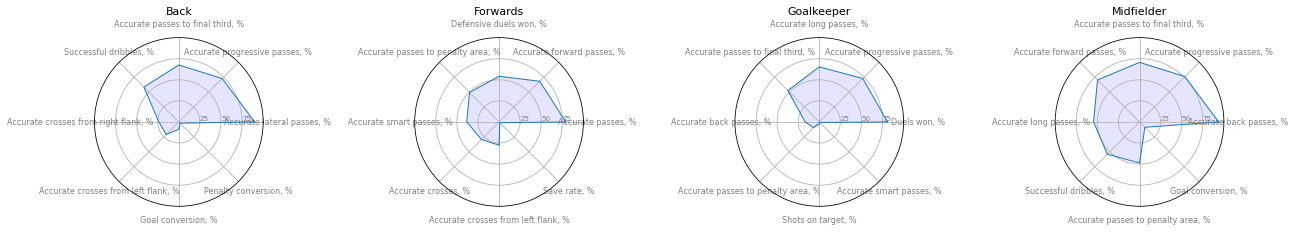

In [13]:
from math import pi
idx = 1
plt.figure(figsize=(22,45))
for i, features in df_feature.iterrows():
    top_features = dict(features.nlargest(8))
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = list(top_features.values())
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(10, 4, idx, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    

    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(i, size=11, y=1.1)
    
    idx += 1

plt.savefig('prediction1.png',dpi=600)

[19:53:59] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:59] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


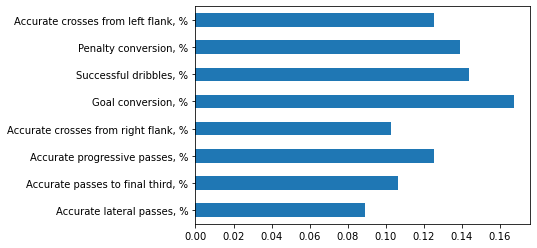

In [55]:
features_choose_back=['Accurate lateral passes, %',
       'Accurate passes to final third, %', 'Accurate progressive passes, %',
       'Accurate crosses from right flank, %', 'Goal conversion, %',
       'Successful dribbles, %', 'Penalty conversion, %',
       'Accurate crosses from left flank, %']
y_back = np.log10(back['Market value'])
X_back = back[features_choose_back]
xg_back = xgb.XGBRegressor(objective ='reg:linear')
xg_back.fit(X_back,y_back)
feat_importances1 = pd.Series(xg_back.feature_importances_, index=X_back.columns)
feat_importances1.plot(kind='barh')
plt.show()
feat_importances1.to_csv('p_back.csv')

In [44]:
from sklearn.metrics import mean_squared_error
y1 = np.log10(back['Market value']).values
X1= back[features_choose_back]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)
xg1 = xgb.XGBRegressor(objective ='reg:linear')
xg1.fit(X_train1,y_train1)
preds1 = xg1.predict(X_test1)
rmse1 = np.sqrt(mean_squared_error(y_test1, preds1))
rmse1

[19:15:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


0.5404661738282212

In [11]:
forward.columns

Index(['Player', 'Market value', 'Accurate forward passes, %',
       'Accurate smart passes, %', 'Accurate crosses, %', 'Save rate, %',
       'Accurate passes, %', 'Defensive duels won, %',
       'Accurate passes to penalty area, %',
       'Accurate crosses from left flank, %'],
      dtype='object')

[19:53:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:32] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


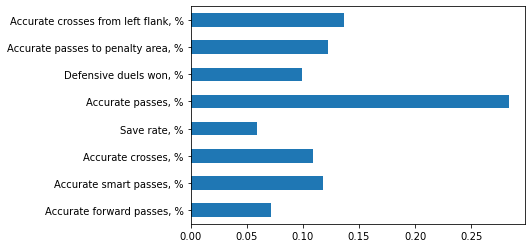

In [54]:
features_choose_forward=['Accurate forward passes, %',
       'Accurate smart passes, %', 'Accurate crosses, %', 'Save rate, %',
       'Accurate passes, %', 'Defensive duels won, %',
       'Accurate passes to penalty area, %',
       'Accurate crosses from left flank, %']
y_forward = np.log10(forward['Market value'])
X_forward = forward[features_choose_forward]
xg_forward = xgb.XGBRegressor(objective ='reg:linear')
xg_forward.fit(X_forward,y_forward)
feat_importances2 = pd.Series(xg_forward.feature_importances_, index=X_forward.columns)
feat_importances2.plot(kind='barh')
plt.show()
feat_importances2.to_csv('p_forward.csv')

In [45]:
y2 = np.log10(forward['Market value'])
X2 = forward[features_choose_forward]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)
xg2 = xgb.XGBRegressor(objective ='reg:linear')
xg2.fit(X_train2,y_train2)
preds2 = xg2.predict(X_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, preds2))
rmse2

[19:16:19] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:16:19] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


0.6378089885697646

In [15]:
gk.columns

Index(['Player', 'Market value', 'Accurate passes to final third, %',
       'Accurate long passes, %', 'Accurate passes to penalty area, %',
       'Accurate progressive passes, %', 'Accurate smart passes, %',
       'Accurate back passes, %', 'Duels won, %', 'Shots on target, %'],
      dtype='object')

[19:54:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


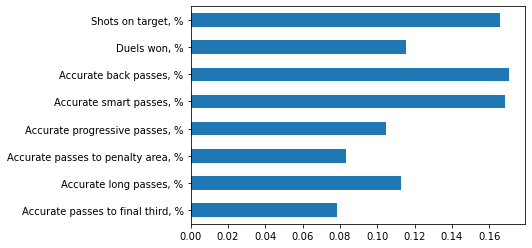

In [56]:
features_choose_gk=['Accurate passes to final third, %',
       'Accurate long passes, %', 'Accurate passes to penalty area, %',
       'Accurate progressive passes, %', 'Accurate smart passes, %',
       'Accurate back passes, %', 'Duels won, %', 'Shots on target, %']
y_gk = np.log10(gk['Market value'])
X_gk = gk[features_choose_gk]
xg_gk = xgb.XGBRegressor(objective ='reg:linear')
xg_gk.fit(X_gk,y_gk)
feat_importances3 = pd.Series(xg_gk.feature_importances_, index=X_gk.columns)
feat_importances3.plot(kind='barh')
plt.show()
feat_importances3.to_csv('p_gk.csv')

In [48]:
y3 = np.log10(gk['Market value'])
X3 = gk[features_choose_gk]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.33, random_state=42)
xg3 = xgb.XGBRegressor(objective ='reg:linear')
xg3.fit(X_train3,y_train3)
preds3 = xg3.predict(X_test3)
rmse3 = np.sqrt(mean_squared_error(y_test3, preds3))
rmse3

[19:17:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


0.5426223269785793

In [17]:
midfield.columns

Index(['Player', 'Market value', 'Accurate long passes, %',
       'Goal conversion, %', 'Accurate progressive passes, %',
       'Accurate passes to penalty area, %', 'Successful dribbles, %',
       'Accurate passes to final third, %', 'Accurate forward passes, %',
       'Accurate back passes, %'],
      dtype='object')

[19:54:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:46] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


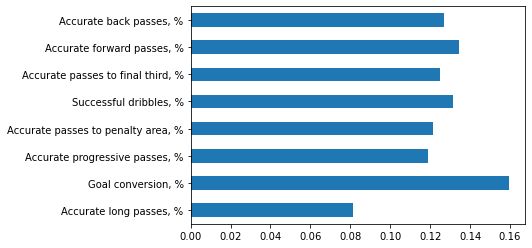

In [57]:
features_choose_midfield=['Accurate long passes, %',
       'Goal conversion, %', 'Accurate progressive passes, %',
       'Accurate passes to penalty area, %', 'Successful dribbles, %',
       'Accurate passes to final third, %', 'Accurate forward passes, %','Accurate back passes, %']
y_midfield = np.log10(midfield['Market value'])
X_midfield = midfield[features_choose_midfield]
xg_midfield = xgb.XGBRegressor(objective ='reg:linear')
xg_midfield.fit(X_midfield,y_midfield)
feat_importances4 = pd.Series(xg_midfield.feature_importances_, index=X_midfield.columns)
feat_importances4.plot(kind='barh')
plt.show()
feat_importances4.to_csv('p_midfield.csv')

In [50]:
y4 = np.log10(midfield['Market value'])
X4 = midfield[features_choose_midfield]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.33, random_state=42)
xg4 = xgb.XGBRegressor(objective ='reg:linear')
xg4.fit(X_train4,y_train4)
preds4 = xg4.predict(X_test4)
rmse4 = np.sqrt(mean_squared_error(y_test4, preds4))
rmse4

[19:18:29] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:29] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


0.5275389149089964

# Optimization

In [3]:
back.General_position = 'Back'
forw.General_position = 'Forwards'
goal.General_position = 'Goalkeeper'
mid.General_position = 'Midfielder'

In [4]:
back.columns

Index(['Unnamed: 0', 'Received passes per 90', 'Matches played', 'Age',
       'Birth_diff_Passport', 'Accurate lateral passes, %',
       'Back passes per 90', 'Progressive passes per 90',
       'Received long passes per 90', 'Passes to penalty area per 90', 'xG',
       'Weight', 'Fouls per 90', 'Yellow cards', 'Fouls suffered per 90',
       'Dribbles per 90', 'Accurate passes to final third, %',
       'Average pass length, m', 'Shots per 90', 'Foot', 'Assists',
       'Penalties taken', 'Shot assists per 90', 'Touches in box per 90', 'xA',
       'Forward passes per 90', 'Through passes per 90',
       'Accurate progressive passes, %', 'Head goals',
       'Accurate crosses from right flank, %', 'PAdj Interceptions',
       'Goal conversion, %', 'Crosses from right flank per 90',
       'Defensive duels per 90', 'Successful dribbles, %',
       'Average long pass length, m', 'On loan', 'Shots blocked per 90',
       'Back passes received as GK per 90', 'Yellow cards per 90', 'Red

In [5]:
forw.columns

Index(['Unnamed: 0', 'Matches played', 'Received passes per 90',
       'Crosses from right flank per 90', 'Shot assists per 90', 'Weight',
       'xA', 'Accurate forward passes, %', 'Age', 'Birth_diff_Passport',
       'Minutes played', 'Smart passes per 90', 'Accurate smart passes, %',
       'Touches in box per 90', 'Through passes per 90', 'Accurate crosses, %',
       'Deep completions per 90', 'Save rate, %', 'Accurate passes, %',
       'Shots blocked per 90', 'Progressive runs per 90',
       'Fouls suffered per 90', 'PAdj Sliding tackles',
       'Defensive duels won, %', 'Non-penalty goals per 90',
       'Second assists per 90', 'xG', 'Accurate passes to penalty area, %',
       'xG per 90', 'Accurate crosses from left flank, %', 'predicted_wage',
       'Player', 'General_position'],
      dtype='object')

In [6]:
fifa.columns

Index(['General_position', 'index', 'ID', 'Name', 'Age', 'Nationality',
       'Overall', 'Potential', 'Club', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'Weak Foot', 'Skill Moves',
       'International Reputation', 'Work Rate', 'Body Type', 'Real Face',
       'Release Clause', 'Position', 'Height', 'Weight', 'Crossing',
       'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys',
       'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Defensive Awareness', 'Standing Tackle', 'Sliding Tackle',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'General_position.1', 'rate_gap', 'predict_position',
       'cost'],
      dtype='object')

In [7]:
backcol = ['Player', 'General_position', 'predicted_wage']
for i in list(back.columns):
    if '%' in i:
        backcol.append(i)

forwcol = ['Player', 'General_position', 'predicted_wage']
for i in list(forw.columns):
    if '%' in i:
        forwcol.append(i)

goalcol = ['Player', 'General_position', 'predicted_wage']
for i in list(goal.columns):
    if '%' in i:
        goalcol.append(i)

midcol = ['Player', 'General_position', 'predicted_wage']
for i in list(mid.columns):
    if '%' in i:
        midcol.append(i)

In [8]:
backcol

['Player',
 'General_position',
 'predicted_wage',
 'Accurate lateral passes, %',
 'Accurate passes to final third, %',
 'Accurate progressive passes, %',
 'Accurate crosses from right flank, %',
 'Goal conversion, %',
 'Successful dribbles, %',
 'Penalty conversion, %',
 'Accurate crosses from left flank, %']

In [9]:
forw.columns

Index(['Unnamed: 0', 'Matches played', 'Received passes per 90',
       'Crosses from right flank per 90', 'Shot assists per 90', 'Weight',
       'xA', 'Accurate forward passes, %', 'Age', 'Birth_diff_Passport',
       'Minutes played', 'Smart passes per 90', 'Accurate smart passes, %',
       'Touches in box per 90', 'Through passes per 90', 'Accurate crosses, %',
       'Deep completions per 90', 'Save rate, %', 'Accurate passes, %',
       'Shots blocked per 90', 'Progressive runs per 90',
       'Fouls suffered per 90', 'PAdj Sliding tackles',
       'Defensive duels won, %', 'Non-penalty goals per 90',
       'Second assists per 90', 'xG', 'Accurate passes to penalty area, %',
       'xG per 90', 'Accurate crosses from left flank, %', 'predicted_wage',
       'Player', 'General_position'],
      dtype='object')

In [10]:
back = back[backcol]
forw = forw[forwcol]
goal = goal[goalcol]
mid  = mid[midcol]

In [11]:
features = list(set(backcol + forwcol + goalcol + midcol))
features

['Accurate passes to final third, %',
 'Accurate crosses from left flank, %',
 'predicted_wage',
 'Accurate passes, %',
 'Successful dribbles, %',
 'Penalty conversion, %',
 'Accurate forward passes, %',
 'Shots on target, %',
 'Goal conversion, %',
 'Duels won, %',
 'Accurate passes to penalty area, %',
 'Save rate, %',
 'Accurate smart passes, %',
 'Accurate crosses, %',
 'General_position',
 'Defensive duels won, %',
 'Accurate progressive passes, %',
 'Accurate lateral passes, %',
 'Accurate crosses from right flank, %',
 'Accurate back passes, %',
 'Accurate long passes, %',
 'Player']

In [12]:
back.head()

Player General_position  predicted_wage  \
0               Albian Hajdari             Back     1583456.863   
1        Bright Akwo Arrey-Mbi             Back     2134369.481   
2                   Bryan Hein             Back     1517256.746   
3                   Chadi Riad             Back     2736304.574   
4  Christian Fernandes Marques             Back     1845200.184   

   Accurate lateral passes, %  Accurate passes to final third, %  \
0                   95.120000                              60.38   
1                   96.040000                              68.02   
2                   82.290000                              55.45   
3                   88.242105                              61.61   
4                   96.770000                              66.67   

   Accurate progressive passes, %  Accurate crosses from right flank, %  \
0                       85.940000                              0.000000   
1                       76.520000                              0.000000   
2                       61.440000                              0.000000   
3                       68.767368                             22.041579   
4                       75.650000                              0.000000   

   Goal conversion, %  Successful dribbles, %  Penalty conversion, %  \
0               0.000               66.670000                      0   
1              30.000               55.000000                      0   
2              11.111               53.490000                      0   
3               0.000               58.942895                      0   
4               0.000               80.000000                      0   

   Accurate crosses from left flank, %  
0                             0.000000  
1                           100.000000  
2                            22.500000  
3                             9.977105  
4                             0.000000

In [13]:
backm = back.merge(fifa, left_on='Player', right_on='Name')
forwm = forw.merge(fifa, left_on='Player', right_on='Name')
goalm = goal.merge(fifa, left_on='Player', right_on='Name')
midm = mid.merge(fifa, left_on='Player', right_on='Name')

In [14]:
df = pd.concat([back, forw, goal, mid])

In [15]:
df_feature=df.groupby(df['General_position'])[features].mean()

In [16]:
df_feature

Accurate passes to final third, %  \
General_position                                      
Back                                      61.610000   
Forwards                                        NaN   
Goalkeeper                                49.643421   
Midfielder                                70.423478   

                  Accurate crosses from left flank, %  predicted_wage  \
General_position                                                        
Back                                         9.977105    1.838526e+06   
Forwards                                    18.817632    1.067499e+07   
Goalkeeper                                        NaN    1.992074e+06   
Midfielder                                        NaN    2.312211e+06   

                  Accurate passes, %  Successful dribbles, %  \
General_position                                               
Back                             NaN               58.942895   
Forwards                   75.979211                     NaN   
Goalkeeper                       NaN                     NaN   
Midfielder                       NaN               47.890870   

                  Penalty conversion, %  Accurate forward passes, %  \
General_position                                                      
Back                           1.086957                         NaN   
Forwards                            NaN                      65.185   
Goalkeeper                          NaN                         NaN   
Midfielder                          NaN                      67.345   

                  Shots on target, %  Goal conversion, %  Duels won, %  \
General_position                                                         
Back                             NaN            6.451022           NaN   
Forwards                         NaN                 NaN           NaN   
Goalkeeper                  2.631579                 NaN     65.423684   
Midfielder                       NaN            8.915306           NaN   

                  Accurate passes to penalty area, %  Save rate, %  \
General_position                                                     
Back                                             NaN           NaN   
Forwards                                   45.943421           0.0   
Goalkeeper                                  9.035263           NaN   
Midfielder                                 50.464348           NaN   

                  Accurate smart passes, %  Accurate crosses, %  \
General_position                                                  
Back                                   NaN                  NaN   
Forwards                         36.085263            21.113684   
Goalkeeper                        0.000000                  NaN   
Midfielder                             NaN                  NaN   

                  Defensive duels won, %  Accurate progressive passes, %  \
General_position                                                           
Back                                 NaN                       68.767368   
Forwards                       51.718947                             NaN   
Goalkeeper                           NaN                       66.883421   
Midfielder                           NaN                       74.631304   

                  Accurate lateral passes, %  \
General_position                               
Back                               88.242105   
Forwards                                 NaN   
Goalkeeper                               NaN   
Midfielder                               NaN   

                  Accurate crosses from right flank, %  \
General_position                                         
Back                                         22.041579   
Forwards                                           NaN   
Goalkeeper                                         NaN   
Midfielder                                         NaN   

                  Accurate back passes, %  Accurate long passes, %  
Gen

In [17]:
for i, features in df_feature.iterrows():
    top_features = dict(features.nlargest(9)).keys()
    print(top_features)

dict_keys(['predicted_wage', 'Accurate lateral passes, %', 'Accurate progressive passes, %', 'Accurate passes to final third, %', 'Successful dribbles, %', 'Accurate crosses from right flank, %', 'Accurate crosses from left flank, %', 'Goal conversion, %', 'Penalty conversion, %'])
dict_keys(['predicted_wage', 'Accurate passes, %', 'Accurate forward passes, %', 'Defensive duels won, %', 'Accurate passes to penalty area, %', 'Accurate smart passes, %', 'Accurate crosses, %', 'Accurate crosses from left flank, %', 'Save rate, %'])
dict_keys(['predicted_wage', 'Accurate progressive passes, %', 'Accurate long passes, %', 'Duels won, %', 'Accurate passes to final third, %', 'Accurate back passes, %', 'Accurate passes to penalty area, %', 'Shots on target, %', 'Accurate smart passes, %'])
dict_keys(['predicted_wage', 'Accurate back passes, %', 'Accurate progressive passes, %', 'Accurate passes to final third, %', 'Accurate forward passes, %', 'Accurate passes to penalty area, %', 'Accurate l

In [18]:
defence=pd.DataFrame({'Accurate lateral passes, %': 88.24210526260869, 'Accurate progressive passes, %': 68.76736842086956, 'Accurate passes to final third, %': 61.61000000000002, 'Successful dribbles, %': 58.9428947373913, 'Accurate crosses from right flank, %': 22.04157894782609, 'Accurate crosses from left flank, %': 9.977105263130435, 'Goal conversion, %': 6.451021739130435, 'Penalty conversion, %': 1.0869565217391304},index=['Defense']).T
defence.to_csv('de.csv')
forwards=pd.DataFrame({'Accurate passes, %': 75.97921052708331, 'Accurate forward passes, %': 65.18499999999999, 'Defensive duels won, %': 51.71894736875, 'Accurate passes to penalty area, %': 45.943421052083345, 'Accurate smart passes, %': 36.08526315833334, 'Accurate crosses, %': 21.113684210416665, 'Accurate crosses from left flank, %': 18.81763157916667, 'Save rate, %': 0.0},index=['Forwards']).T
forwards.to_csv('fo.csv')
GK=pd.DataFrame({'Accurate progressive passes, %': 66.88342105217393, 'Accurate long passes, %': 65.99421052695651, 'Duels won, %': 65.42368421043477, 'Accurate passes to final third, %': 49.643421052173906, 'Accurate back passes, %': 13.157894737391304, 'Accurate passes to penalty area, %': 9.035263157913043, 'Shots on target, %': 2.6315789473043476, 'Accurate smart passes, %': 0.0},index=['GK']).T
GK.to_csv('go.csv')
Midfielder=pd.DataFrame({'Accurate back passes, %': 92.72065217367346, 'Accurate progressive passes, %': 74.63130434795917, 'Accurate passes to final third, %': 70.42347826081632, 'Accurate forward passes, %': 67.34499999999997, 'Accurate passes to penalty area, %': 50.46434782632653, 'Accurate long passes, %': 49.47760869591838, 'Successful dribbles, %': 47.890869565510194, 'Goal conversion, %': 8.915306122448982},index=['Midfielder']).T
Midfielder.to_csv('Mi.csv')

In [19]:
# from math import pi
# idx = 1
# plt.figure(figsize=(22,45))
# for i, features in df_feature.iterrows():
#     top_features = dict(features.nlargest(8))
    
#     # number of variable
#     categories=top_features.keys()
#     N = len(categories)

#     # We are going to plot the first line of the data frame.
#     # But we need to repeat the first value to close the circular graph:
#     values = list(top_features.values())
#     values += values[:1]

#     # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
#     angles = [n / float(N) * 2 * pi for n in range(N)]
#     angles += angles[:1]

#     # Initialise the spider plot
#     ax = plt.subplot(10, 4, idx, polar=True)

#     # Draw one axe per variable + add labels labels yet
#     plt.xticks(angles[:-1], categories, color='grey', size=8)
#  # Draw ylabels
#     ax.set_rlabel_position(0)
#     plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
#     plt.ylim(0,100)
    

#     plt.subplots_adjust(hspace = 0.5)
    
#     # Plot data
#     ax.plot(angles, values, linewidth=1, linestyle='solid')

#     # Fill area
#     ax.fill(angles, values, 'b', alpha=0.1)
    
#     plt.title(i, size=11, y=1.1)
    
#     idx += 1

# plt.savefig('prediction1.png',dpi=600)

# for full features

In [20]:
ea = pd.read_csv('/Users/Amphetamine/Downloads/Positions_500ea.csv')

In [21]:
features = list(set(backcol + forwcol + goalcol + midcol))
features.remove('predicted_wage')
ea = ea[features]

In [23]:
df2_feature=ea.groupby(ea['General_position'])[features].mean()

In [24]:
df2_feature

Accurate passes to final third, %  \
General_position                                      
Back                                      67.799493   
Forward                                   68.779414   
Goalkeeper                                52.721118   
Midfield                                  71.116789   

                  Accurate crosses from left flank, %  Accurate passes, %  \
General_position                                                            
Back                                        20.547773           84.589573   
Forward                                     27.654390           79.085824   
Goalkeeper                                   0.210970           84.830738   
Midfield                                    28.970608           81.477613   

                  Successful dribbles, %  Penalty conversion, %  \
General_position                                                  
Back                           58.614470               1.776826   
Forward                        51.062233              28.145701   
Goalkeeper                     30.474726               0.400000   
Midfield                       54.164949              13.281346   

                  Accurate forward passes, %  Shots on target, %  \
General_position                                                   
Back                               75.040012           30.385847   
Forward                            68.141475           39.565217   
Goalkeeper                         77.008924            2.278481   
Midfield                           70.853481           32.950318   

                  Goal conversion, %  Duels won, %  \
General_position                                     
Back                        8.919928     58.564017   
Forward                    13.515734     43.513611   
Goalkeeper                  0.680000     80.940717   
Midfield                    9.039255     48.111467   

                  Accurate passes to penalty area, %  Save rate, %  \
General_position                                                     
Back                                       37.084336      0.028571   
Forward                                    50.107202      1.182580   
Goalkeeper                                  9.387595     70.411420   
Midfield                                   49.120580      0.057143   

                  Accurate smart passes, %  Accurate crosses, %  \
General_position                                                  
Back                             33.777142            30.099034   
Forward                          38.496416            29.421316   
Goalkeeper                        0.843882             0.421941   
Midfield                         39.635847            32.990828   

                  Defensive duels won, %  Accurate progressive passes, %  \
General_position                                                           
Back                           64.229277                       72.566102   
Forward                        53.994466                       75.661558   
Goalkeeper                     47.621730                       72.918882   
Midfield                       56.200483                       76.277593   

                  Accurate lateral passes, %  \
General_position                               
Back                               90.920912   
Forward                            79.442047   
Goalkeeper                         97.043249   
Midfield                           84.123119   

                  Accurate crosses from right flank, %  \
General_position                                         
Back                                         23.736046   
Forward                                      29.057491   
Goalkeeper                                    0.000000   
Midfield                                     31.730993   

                  Accurate back passes, %  Accurate long passes, %  
General_position                                                    
Back                          

In [25]:
for i, features in df2_feature.iterrows():
    top_features = dict(features.nlargest(8))
    print(top_features)

{'Accurate back passes, %': 94.88813092417033, 'Accurate lateral passes, %': 90.92091232227516, 'Accurate passes, %': 84.58957345971568, 'Accurate forward passes, %': 75.04001184834134, 'Accurate progressive passes, %': 72.56610189573503, 'Accurate passes to final third, %': 67.79949348341252, 'Defensive duels won, %': 64.22927725118508, 'Successful dribbles, %': 58.61446978673016}
{'Accurate back passes, %': 90.80972432804964, 'Accurate lateral passes, %': 79.44204686423157, 'Accurate passes, %': 79.08582356995153, 'Accurate progressive passes, %': 75.66155754651975, 'Accurate passes to final third, %': 68.77941419710533, 'Accurate forward passes, %': 68.14147484493446, 'Accurate long passes, %': 55.470096485182644, 'Defensive duels won, %': 53.99446588559615}
{'Accurate lateral passes, %': 97.04324894514767, 'Accurate passes, %': 84.8307383966245, 'Duels won, %': 80.94071729957801, 'Accurate forward passes, %': 77.00892405063291, 'Accurate progressive passes, %': 72.9188818565402, 'S

In [26]:
# from math import pi
# idx = 1
# plt.figure(figsize=(22,45))
# for i, features in df2_feature.iterrows():
#     top_features = dict(features.nlargest(8))
    
#     # number of variable
#     categories=top_features.keys()
#     N = len(categories)

#     # We are going to plot the first line of the data frame.
#     # But we need to repeat the first value to close the circular graph:
#     values = list(top_features.values())
#     values += values[:1]

#     # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
#     angles = [n / float(N) * 2 * pi for n in range(N)]
#     angles += angles[:1]

#     # Initialise the spider plot
#     ax = plt.subplot(10, 4, idx, polar=True)

#     # Draw one axe per variable + add labels labels yet
#     plt.xticks(angles[:-1], categories, color='grey', size=8)
#  # Draw ylabels
#     ax.set_rlabel_position(0)
#     plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
#     plt.ylim(0,100)
    

#     plt.subplots_adjust(hspace = 0.5)
    
#     # Plot data
#     ax.plot(angles, values, linewidth=1, linestyle='solid')

#     # Fill area
#     ax.fill(angles, values, 'b', alpha=0.1)
    
#     plt.title(i, size=11, y=1.1)
    
#     idx += 1

# plt.savefig('prediction2.png',dpi=600)

# for accuracy

In [28]:
defence=pd.DataFrame({'Accurate lateral passes, %': 88.24210526260869, 'Accurate progressive passes, %': 68.76736842086956, 'Accurate passes to final third, %': 61.61000000000002, 'Successful dribbles, %': 58.9428947373913, 'Accurate crosses from right flank, %': 22.04157894782609, 'Accurate crosses from left flank, %': 9.977105263130435, 'Goal conversion, %': 6.451021739130435, 'Penalty conversion, %': 1.0869565217391304},index=['Defense'])
forwards=pd.DataFrame({'Accurate passes, %': 75.97921052708331, 'Accurate forward passes, %': 65.18499999999999, 'Defensive duels won, %': 51.71894736875, 'Accurate passes to penalty area, %': 45.943421052083345, 'Accurate smart passes, %': 36.08526315833334, 'Accurate crosses, %': 21.113684210416665, 'Accurate crosses from left flank, %': 18.81763157916667, 'Save rate, %': 0.0},index=['Forwards'])
GK=pd.DataFrame({'Accurate progressive passes, %': 66.88342105217393, 'Accurate long passes, %': 65.99421052695651, 'Duels won, %': 65.42368421043477, 'Accurate passes to final third, %': 49.643421052173906, 'Accurate back passes, %': 13.157894737391304, 'Accurate passes to penalty area, %': 9.035263157913043, 'Shots on target, %': 2.6315789473043476, 'Accurate smart passes, %': 0.0},index=['GK'])
Midfielder=pd.DataFrame({'Accurate back passes, %': 92.72065217367346, 'Accurate progressive passes, %': 74.63130434795917, 'Accurate passes to final third, %': 70.42347826081632, 'Accurate forward passes, %': 67.34499999999997, 'Accurate passes to penalty area, %': 50.46434782632653, 'Accurate long passes, %': 49.47760869591838, 'Successful dribbles, %': 47.890869565510194, 'Goal conversion, %': 8.915306122448982},index=['Midfielder'])

# for physical 

In [29]:
defence=pd.concat((defence, pd.DataFrame({'Strength': 70.17912238601302, 'Jumping': 69.21438356164384, 'Stamina': 67.26322115384616, 'Standing Tackle': 66.8834618680377, 'Aggression': 65.94249146757679, 'Sprint Speed': 65.51315563198624, 'Sliding Tackle': 65.2226033270451, 'Acceleration': 64.38741210770023},index=['Defense'])), axis = 1)
forwards=pd.concat((forwards, pd.DataFrame({'Strength': 69.74161533196441, 'Sprint Speed': 69.62453023573624, 'Acceleration': 68.71788756388416, 'Jumping': 68.07340389211335, 'Shot Power': 67.79011925042589, 'Finishing': 67.68576329331046, 'Agility': 66.78277153558052, 'Positioning': 66.7501704158146},index=['Forwards'])), axis = 1)
GK=pd.concat((GK, pd.DataFrame({'GK Reflexes': 67.64916330063474, 'GK Diving': 66.65650172612197, 'GK Positioning': 64.93602305475504, 'GK Handling': 64.40932642487047, 'GK Kicking': 63.027570361861, 'Strength': 60.93621867881549, 'Reactions': 60.36264367816092, 'Jumping': 58.55251141552512},index=['GK'])), axis = 1)
Midfielder=pd.concat((Midfielder, pd.DataFrame({'Balance': 71.67303255575493, 'Agility': 71.42982117586517, 'Acceleration': 70.49652599073598, 'Sprint Speed': 69.3224395265054, 'Ball Control': 68.0047557840617, 'Short Passing': 67.153470437018, 'Stamina': 67.11009292720702, 'Dribbling': 67.00783860190182},index=['Midfielder'])), axis = 1)

In [30]:
backcal = backm[['Player', 'General_position_x', 'predicted_wage',
 'Accurate lateral passes, %', 'Accurate progressive passes, %',
       'Accurate passes to final third, %', 'Successful dribbles, %',
       'Accurate crosses from right flank, %',
       'Accurate crosses from left flank, %', 'Goal conversion, %',
       'Penalty conversion, %', 'Strength', 'Jumping', 'Stamina', 'Standing Tackle', 'Aggression', 'Sprint Speed', 'Sliding Tackle', 'Acceleration', 'cost']]
backcal.head()

Player General_position_x  predicted_wage  \
0               Albian Hajdari               Back     1583456.863   
1        Bright Akwo Arrey-Mbi               Back     2134369.481   
2                   Bryan Hein               Back     1517256.746   
3                   Chadi Riad               Back     2736304.574   
4  Christian Fernandes Marques               Back     1845200.184   

   Accurate lateral passes, %  Accurate progressive passes, %  \
0                   95.120000                       85.940000   
1                   96.040000                       76.520000   
2                   82.290000                       61.440000   
3                   88.242105                       68.767368   
4                   96.770000                       75.650000   

   Accurate passes to final third, %  Successful dribbles, %  \
0                              60.38               66.670000   
1                              68.02               55.000000   
2                              55.45               53.490000   
3                              61.61               58.942895   
4                              66.67               80.000000   

   Accurate crosses from right flank, %  Accurate crosses from left flank, %  \
0                              0.000000                             0.000000   
1                              0.000000                           100.000000   
2                              0.000000                            22.500000   
3                             22.041579                             9.977105   
4                              0.000000                             0.000000   

   Goal conversion, %  Penalty conversion, %  Strength  Jumping  Stamina  \
0               0.000                      0        68       66       56   
1              30.000                      0        71       78       62   
2              11.111                      0        53       58       64   
3               0.000                      0        56       65       60   
4               0.000                      0        64       68       65   

   Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  Acceleration  \
0               58          51            61              52            58   
1               64          63            70              61            66   
2               59          50            71              54            72   
3               67          54            58              65            59   
4               60          53            49              59            53   

   cost  
0     0  
1     0  
2     0  
3     0  
4     0

In [31]:
defence

Accurate lateral passes, %  Accurate progressive passes, %  \
Defense                   88.242105                       68.767368   

         Accurate passes to final third, %  Successful dribbles, %  \
Defense                              61.61               58.942895   

         Accurate crosses from right flank, %  \
Defense                             22.041579   

         Accurate crosses from left flank, %  Goal conversion, %  \
Defense                             9.977105            6.451022   

         Penalty conversion, %   Strength    Jumping    Stamina  \
Defense               1.086957  70.179122  69.214384  67.263221   

         Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  \
Defense        66.883462   65.942491     65.513156       65.222603   

         Acceleration  
Defense     64.387412

In [32]:
forwards

Accurate passes, %  Accurate forward passes, %  \
Forwards           75.979211                      65.185   

          Defensive duels won, %  Accurate passes to penalty area, %  \
Forwards               51.718947                           45.943421   

          Accurate smart passes, %  Accurate crosses, %  \
Forwards                 36.085263            21.113684   

          Accurate crosses from left flank, %  Save rate, %   Strength  \
Forwards                            18.817632           0.0  69.741615   

          Sprint Speed  Acceleration    Jumping  Shot Power  Finishing  \
Forwards      69.62453     68.717888  68.073404   67.790119  67.685763   

            Agility  Positioning  
Forwards  66.782772     66.75017

In [33]:
GK

Accurate progressive passes, %  Accurate long passes, %  Duels won, %  \
GK                       66.883421                65.994211     65.423684   

    Accurate passes to final third, %  Accurate back passes, %  \
GK                          49.643421                13.157895   

    Accurate passes to penalty area, %  Shots on target, %  \
GK                            9.035263            2.631579   

    Accurate smart passes, %  GK Reflexes  GK Diving  GK Positioning  \
GK                       0.0    67.649163  66.656502       64.936023   

    GK Handling  GK Kicking   Strength  Reactions    Jumping  
GK    64.409326    63.02757  60.936219  60.362644  58.552511

In [34]:
Midfielder

Accurate back passes, %  Accurate progressive passes, %  \
Midfielder                92.720652                       74.631304   

            Accurate passes to final third, %  Accurate forward passes, %  \
Midfielder                          70.423478                      67.345   

            Accurate passes to penalty area, %  Accurate long passes, %  \
Midfielder                           50.464348                49.477609   

            Successful dribbles, %  Goal conversion, %    Balance    Agility  \
Midfielder                47.89087            8.915306  71.673033  71.429821   

            Acceleration  Sprint Speed  Ball Control  Short Passing  \
Midfielder     70.496526      69.32244     68.004756       67.15347   

              Stamina  Dribbling  
Midfielder  67.110093  67.007839

In [35]:
backcal['dist_BA'] = 0
backcal['dist_FO'] = 0
backcal['dist_GK'] = 0
backcal['dist_MI'] = 0

# for weightage matrix

In [36]:
backwei = pd.read_csv('/Users/Amphetamine/Downloads/weightage/p_back.csv')
forwwei = pd.read_csv('/Users/Amphetamine/Downloads/weightage/p_forward.csv')
goalwei = pd.read_csv('/Users/Amphetamine/Downloads/weightage/p_gk.csv')
midwei = pd.read_csv('/Users/Amphetamine/Downloads/weightage/p_midfield.csv')
backwei2 = pd.read_csv('/Users/Amphetamine/Downloads/weightage/para_def.csv')
forwwei2 = pd.read_csv('/Users/Amphetamine/Downloads/weightage/para_for.csv')
goalwei2 = pd.read_csv('/Users/Amphetamine/Downloads/weightage/para_gk.csv')
midwei2 = pd.read_csv('/Users/Amphetamine/Downloads/weightage/para_mid.csv')

In [37]:
backwei = backwei[['Accurate lateral passes, %', 'Accurate progressive passes, %', 'Accurate passes to final third, %', 'Successful dribbles, %', 'Accurate crosses from right flank, %', 'Accurate crosses from left flank, %', 'Goal conversion, %', 'Penalty conversion, %']]
forwwei = forwwei[['Accurate passes, %', 'Accurate forward passes, %', 'Defensive duels won, %', 'Accurate passes to penalty area, %', 'Accurate smart passes, %', 'Accurate crosses, %', 'Accurate crosses from left flank, %', 'Save rate, %']]
goalwei = goalwei[['Accurate progressive passes, %', 'Accurate long passes, %', 'Duels won, %', 'Accurate passes to final third, %', 'Accurate back passes, %', 'Accurate passes to penalty area, %', 'Shots on target, %', 'Accurate smart passes, %']]
midwei = midwei[['Accurate back passes, %', 'Accurate progressive passes, %', 'Accurate passes to final third, %', 'Accurate forward passes, %', 'Accurate passes to penalty area, %', 'Accurate long passes, %', 'Successful dribbles, %', 'Goal conversion, %']]

In [38]:
backweight = pd.concat((backwei, backwei2), axis=1)/2
forwweight = pd.concat((forwwei, forwwei2), axis=1)/2
goalweight = pd.concat((goalwei, goalwei2), axis=1)/2
midweight = pd.concat((midwei, midwei2), axis=1)/2

In [39]:
backweight

Accurate lateral passes, %  Accurate progressive passes, %  \
0                    0.045169                        0.052817   

   Accurate passes to final third, %  Successful dribbles, %  \
0                           0.067234                0.055677   

   Accurate crosses from right flank, %  Accurate crosses from left flank, %  \
0                              0.051589                               0.0727   

   Goal conversion, %  Penalty conversion, %  Strength   Jumping   Stamina  \
0            0.071482               0.083333  0.008876  0.012546  0.022064   

   Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  Acceleration  
0             0.12    0.014002       0.03279        0.235538      0.054184

In [40]:
forwweight

Accurate passes, %  Accurate forward passes, %  Defensive duels won, %  \
0            0.146107                    0.029025                0.053773   

   Accurate passes to penalty area, %  Accurate smart passes, %  \
0                            0.059582                  0.048519   

   Accurate crosses, %  Accurate crosses from left flank, %  Save rate, %  \
0              0.05144                             0.045279      0.066275   

   Strength  Sprint Speed  Acceleration   Jumping  Shot Power  Finishing  \
0  0.007084      0.021551      0.011955  0.032979    0.020269   0.293511   

    Agility  Positioning  
0  0.037843     0.074808

In [41]:
goalweight

Accurate progressive passes, %  Accurate long passes, %  Duels won, %  \
0                        0.035485                 0.018116      0.013894   

   Accurate passes to final third, %  Accurate back passes, %  \
0                            0.01463                 0.010738   

   Accurate passes to penalty area, %  Shots on target, %  \
0                            0.058665             0.23952   

   Accurate smart passes, %  GK Reflexes  GK Diving  GK Positioning  \
0                  0.108953     0.274216   0.090693        0.016175   

   GK Handling  GK Kicking  Strength  Reactions   Jumping  
0     0.022066    0.013166  0.007823    0.06932  0.006541

In [42]:
midweight

Accurate back passes, %  Accurate progressive passes, %  \
0                   0.0558                        0.073092   

   Accurate passes to final third, %  Accurate forward passes, %  \
0                           0.048041                     0.06422   

   Accurate passes to penalty area, %  Accurate long passes, %  \
0                            0.074848                 0.049547   

   Successful dribbles, %  Goal conversion, %   Balance   Agility  \
0                0.056091            0.078361  0.009458  0.013836   

   Acceleration  Sprint Speed  Ball Control  Short Passing   Stamina  \
0      0.013892      0.021099      0.310118       0.027547  0.055773   

   Dribbling  
0   0.048277

In [43]:
backcal.head()

Player General_position_x  predicted_wage  \
0               Albian Hajdari               Back     1583456.863   
1        Bright Akwo Arrey-Mbi               Back     2134369.481   
2                   Bryan Hein               Back     1517256.746   
3                   Chadi Riad               Back     2736304.574   
4  Christian Fernandes Marques               Back     1845200.184   

   Accurate lateral passes, %  Accurate progressive passes, %  \
0                   95.120000                       85.940000   
1                   96.040000                       76.520000   
2                   82.290000                       61.440000   
3                   88.242105                       68.767368   
4                   96.770000                       75.650000   

   Accurate passes to final third, %  Successful dribbles, %  \
0                              60.38               66.670000   
1                              68.02               55.000000   
2                              55.45               53.490000   
3                              61.61               58.942895   
4                              66.67               80.000000   

   Accurate crosses from right flank, %  Accurate crosses from left flank, %  \
0                              0.000000                             0.000000   
1                              0.000000                           100.000000   
2                              0.000000                            22.500000   
3                             22.041579                             9.977105   
4                              0.000000                             0.000000   

   Goal conversion, %  Penalty conversion, %  Strength  Jumping  Stamina  \
0               0.000                      0        68       66       56   
1              30.000                      0        71       78       62   
2              11.111                      0        53       58       64   
3               0.000                      0        56       65       60   
4               0.000                      0        64       68       65   

   Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  Acceleration  \
0               58          51            61              52            58   
1               64          63            70              61            66   
2               59          50            71              54            72   
3               67          54            58              65            59   
4               60          53            49              59            53   

   cost  dist_BA  dist_FO  dist_GK  dist_MI  
0     0        0        0        0        0  
1     0        0        0        0        0  
2     0        0        0        0        0  
3     0        0        0        0        0  
4     0        0        0        0        0

In [44]:
# initial try
backcal.loc[0, 'dist_BA'] = sum(backweight.iloc[0, i] * (defence.iloc[0,i] - backcal.iloc[0,i+3]) for i in range(16))

In [45]:
for j in range(len(backcal)):
    backcal.loc[j, 'dist_BA'] = sum(backweight.iloc[0, i] * (defence.iloc[0,i] - backcal.iloc[j,i+3]) for i in range(16))
    backcal.loc[j, 'dist_FO'] = sum(backweight.iloc[0, i] * (forwards.iloc[0,i] - backcal.iloc[j,i+3]) for i in range(16))
    backcal.loc[j, 'dist_GK'] = sum(backweight.iloc[0, i] * (GK.iloc[0,i] - backcal.iloc[j,i+3]) for i in range(16))
    backcal.loc[j, 'dist_MI'] = sum(backweight.iloc[0, i] * (Midfielder.iloc[0,i] - backcal.iloc[j,i+3]) for i in range(16))

In [46]:
backcal.head()

Player General_position_x  predicted_wage  \
0               Albian Hajdari               Back     1583456.863   
1        Bright Akwo Arrey-Mbi               Back     2134369.481   
2                   Bryan Hein               Back     1517256.746   
3                   Chadi Riad               Back     2736304.574   
4  Christian Fernandes Marques               Back     1845200.184   

   Accurate lateral passes, %  Accurate progressive passes, %  \
0                   95.120000                       85.940000   
1                   96.040000                       76.520000   
2                   82.290000                       61.440000   
3                   88.242105                       68.767368   
4                   96.770000                       75.650000   

   Accurate passes to final third, %  Successful dribbles, %  \
0                              60.38               66.670000   
1                              68.02               55.000000   
2                              55.45               53.490000   
3                              61.61               58.942895   
4                              66.67               80.000000   

   Accurate crosses from right flank, %  Accurate crosses from left flank, %  \
0                              0.000000                             0.000000   
1                              0.000000                           100.000000   
2                              0.000000                            22.500000   
3                             22.041579                             9.977105   
4                              0.000000                             0.000000   

   Goal conversion, %  Penalty conversion, %  Strength  Jumping  Stamina  \
0               0.000                      0        68       66       56   
1              30.000                      0        71       78       62   
2              11.111                      0        53       58       64   
3               0.000                      0        56       65       60   
4               0.000                      0        64       68       65   

   Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  Acceleration  \
0               58          51            61              52            58   
1               64          63            70              61            66   
2               59          50            71              54            72   
3               67          54            58              65            59   
4               60          53            49              59            53   

   cost   dist_BA   dist_FO    dist_GK    dist_MI  
0     0  6.040892  7.005291   1.723398  16.640091  
1     0 -6.827475 -5.863077 -11.144969   3.771723  
2     0  4.943167  5.907565   0.625673  15.542365  
3     0  1.634624  2.599022  -2.682870  12.233822  
4     0  3.904230  4.868628  -0.413264  14.503428

In [47]:
backcal.describe()
# may need to add 15 to the distance matrix to make it positive

predicted_wage  Accurate lateral passes, %  \
count    4.600000e+01                   46.000000   
mean     1.838526e+06                   88.242105   
std      3.517977e+05                   10.766755   
min      1.393846e+06                   33.330000   
25%      1.588068e+06                   86.807500   
50%      1.788688e+06                   88.242105   
75%      1.991331e+06                   95.165000   
max      3.010658e+06                   99.290000   

       Accurate progressive passes, %  Accurate passes to final third, %  \
count                       46.000000                          46.000000   
mean                        68.767368                          61.610000   
std                          9.727581                          13.756653   
min                         40.000000                           0.000000   
25%                         65.997500                          58.092500   
50%                         68.767368                          61.610000   
75%                         74.632500                          68.822500   
max                         88.890000                          89.470000   

       Successful dribbles, %  Accurate crosses from right flank, %  \
count               46.000000                             46.000000   
mean                58.942895                             22.041579   
std                 22.681409                             29.937186   
min                  0.000000                              0.000000   
25%                 53.630000                              0.000000   
50%                 58.942895                             18.335000   
75%                 64.182500                             24.492500   
max                100.000000                            100.000000   

       Accurate crosses from left flank, %  Goal conversion, %  \
count                            46.000000           46.000000   
mean                              9.977105            6.451022   
std                              22.222189           10.873278   
min                               0.000000            0.000000   
25%                               0.000000            0.000000   
50%                               0.000000            0.000000   
75%                               9.977105           11.924000   
max                             100.000000           50.000000   

       Penalty conversion, %   Strength    Jumping    Stamina  \
count              46.000000  46.000000  46.000000  46.000000   
mean                1.086957  59.326087  64.608696  59.021739   
std                 7.372098   9.968961   7.520279   6.980892   
min                 0.000000  37.000000  35.000000  32.000000   
25%                 0.000000  52.250000  61.000000  57.000000   
50%                 0.000000  59.000000  66.000000  60.000000   
75%                 0.000000  67.750000  69.750000  62.750000   
max                50.000000  77.000000  78.000000  69.000000   

       Standing Tackle  Aggression  Sprint Speed  Sliding Tackle  \
count        46.000000   46.000000     46.000000       46.000000   
mean         57.217391   52.282609     63.108696       55.782609   
std           6.791868    7.532634      8.168308        6.341795   
min          44.000000   31.000000     45.000000       46.000000   
25%          53.000000   48.000000     58.000000       52.000000   
50%          56.500000   51.000000     61.000000       55.000000   
75%          62.000000   55.750000     69.000000       59.750000   
max          77.000000   75.000000     81.000000       72.000000   

       Acceleration       cost    dist_BA    dist_FO    dist_GK    dist_MI  
count     46.000000  46.000000  46.000000  46.000000  46.000000  46.000000  
mean      62.500000   0.065217   4.091739   5.056137  -0.225755  14.690938  
std        8.021499   0.249637   4.830679   4.830679   4.830679   4.830679  
min       45.000000   0.000000  -6.827475  -5.863077 -11.144969   3.771723  
25%       55.750000   0.0

In [48]:
forwcal = forwm[['Player', 'General_position_x', 'predicted_wage',
 'Accurate passes, %', 'Accurate forward passes, %', 'Defensive duels won, %', 'Accurate passes to penalty area, %', 'Accurate smart passes, %', 'Accurate crosses, %', 'Accurate crosses from left flank, %', 'Save rate, %', 'Strength', 'Sprint Speed', 'Acceleration', 'Jumping', 'Shot Power', 'Finishing', 'Agility', 'Positioning', 'cost']]
forwcal.head()

Player General_position_x  predicted_wage  \
0        Andreas Bredahl           Forwards    2.460837e+07   
1          Armando Broja           Forwards    9.589181e+06   
2  Alfonso Ocampo-Chavez           Forwards    1.080923e+07   
3    Aleksander Stawiarz           Forwards    1.544117e+07   
4          Amadou Traoré           Forwards    8.340128e+06   

   Accurate passes, %  Accurate forward passes, %  Defensive duels won, %  \
0           67.390000                      60.710               46.230000   
1           78.650000                      64.810               50.000000   
2           80.700000                      65.490               53.790000   
3           75.979211                      65.185               51.718947   
4           85.730000                      79.060               58.410000   

   Accurate passes to penalty area, %  Accurate smart passes, %  \
0                           62.070000                 40.000000   
1                           55.560000                 14.290000   
2                           57.690000                 28.570000   
3                           45.943421                 36.085263   
4                           64.540000                 61.360000   

   Accurate crosses, %  Accurate crosses from left flank, %  Save rate, %  \
0            36.360000                            36.670000             0   
1            22.220000                             0.000000             0   
2            24.240000                            12.500000             0   
3            21.113684                            18.817632             0   
4            42.590000                            40.000000             0   

   Strength  Sprint Speed  Acceleration  Jumping  Shot Power  Finishing  \
0        54            69            67       53          52         55   
1        68            74            67       62          60         62   
2        44            60            64       62          48         58   
3        42            59            68       60          47         54   
4        63            74            72       66          58         62   

   Agility  Positioning  cost  
0       62           54     0  
1       65           59     0  
2       64           57     0  
3       61           47     0  
4       64           57     0

In [49]:
for j in range(len(forwcal)):
    forwcal.loc[j, 'dist_BA'] = sum(forwweight.iloc[0, i] * (defence.iloc[0,i] - forwcal.iloc[j,i+3]) for i in range(16))
    forwcal.loc[j, 'dist_FO'] = sum(forwweight.iloc[0, i] * (forwards.iloc[0,i] - forwcal.iloc[j,i+3]) for i in range(16))
    forwcal.loc[j, 'dist_GK'] = sum(forwweight.iloc[0, i] * (GK.iloc[0,i] - forwcal.iloc[j,i+3]) for i in range(16))
    forwcal.loc[j, 'dist_MI'] = sum(forwweight.iloc[0, i] * (Midfielder.iloc[0,i] - forwcal.iloc[j,i+3]) for i in range(16))

In [50]:
forwcal.head()

Player General_position_x  predicted_wage  \
0        Andreas Bredahl           Forwards    2.460837e+07   
1          Armando Broja           Forwards    9.589181e+06   
2  Alfonso Ocampo-Chavez           Forwards    1.080923e+07   
3    Aleksander Stawiarz           Forwards    1.544117e+07   
4          Amadou Traoré           Forwards    8.340128e+06   

   Accurate passes, %  Accurate forward passes, %  Defensive duels won, %  \
0           67.390000                      60.710               46.230000   
1           78.650000                      64.810               50.000000   
2           80.700000                      65.490               53.790000   
3           75.979211                      65.185               51.718947   
4           85.730000                      79.060               58.410000   

   Accurate passes to penalty area, %  Accurate smart passes, %  \
0                           62.070000                 40.000000   
1                           55.560000                 14.290000   
2                           57.690000                 28.570000   
3                           45.943421                 36.085263   
4                           64.540000                 61.360000   

   Accurate crosses, %  Accurate crosses from left flank, %  Save rate, %  \
0            36.360000                            36.670000             0   
1            22.220000                             0.000000             0   
2            24.240000                            12.500000             0   
3            21.113684                            18.817632             0   
4            42.590000                            40.000000             0   

   Strength  Sprint Speed  Acceleration  Jumping  Shot Power  Finishing  \
0        54            69            67       53          52         55   
1        68            74            67       62          60         62   
2        44            60            64       62          48         58   
3        42            59            68       60          47         54   
4        63            74            72       66          58         62   

   Agility  Positioning  cost   dist_BA   dist_FO   dist_GK    dist_MI  
0       62           54     0  5.244091  4.757477 -1.235854  13.817432  
1       65           59     0  4.092204  3.605591 -2.387741  12.665545  
2       64           57     0  4.191814  3.705200 -2.288132  12.765155  
3       61           47     0  7.321564  6.834951  0.841619  15.894905  
4       64           57     0 -3.414176 -3.900790 -9.894121   5.159165

In [51]:
goalcal = goalm[['Player', 'General_position_x', 'predicted_wage',
 'Accurate progressive passes, %', 'Accurate long passes, %', 'Duels won, %', 'Accurate passes to final third, %', 'Accurate back passes, %', 'Accurate passes to penalty area, %', 'Shots on target, %', 'Accurate smart passes, %', 'GK Reflexes', 'GK Diving', 'GK Positioning', 'GK Handling', 'GK Kicking', 'Strength', 'Reactions', 'Jumping', 'cost']]
goalcal.head()

Player General_position_x  predicted_wage  \
0       ángel Fortu?o Vi?as         Goalkeeper     1609769.264   
1               Anders Hoff         Goalkeeper     1434790.562   
2             Adam Pavlesic         Goalkeeper     1616645.208   
3          Alessandro Russo         Goalkeeper     1548516.385   
4  Adrián Rodríguez Giménez         Goalkeeper     1261882.452   

   Accurate progressive passes, %  Accurate long passes, %  Duels won, %  \
0                           50.00                    80.00         50.00   
1                           61.29                    63.64         84.21   
2                           47.06                    56.52        100.00   
3                           67.91                    64.01         71.05   
4                           66.67                    60.00        100.00   

   Accurate passes to final third, %  Accurate back passes, %  \
0                               0.00                      0.0   
1                              47.37                      0.0   
2                              33.33                      0.0   
3                              52.24                    100.0   
4                               0.00                      0.0   

   Accurate passes to penalty area, %  Shots on target, %  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                40.0                 0.0   
4                                 0.0                 0.0   

   Accurate smart passes, %  GK Reflexes  GK Diving  GK Positioning  \
0                         0           66         62              63   
1                         0           45         59              53   
2                         0           59         53              56   
3                         0           58         62              45   
4                         0           60         57              62   

   GK Handling  GK Kicking  Strength  Reactions  Jumping  cost  
0           60          61        45         49       70     0  
1           50          51        41         33       44     0  
2           55          53        42         38       46     0  
3           55          51        63         41       38     0  
4           58          64        65         52       38     0

In [52]:
for j in range(len(goalcal)):
    goalcal.loc[j, 'dist_BA'] = sum(goalweight.iloc[0, i] * (defence.iloc[0,i] - goalcal.iloc[j,i+3]) for i in range(16))
    goalcal.loc[j, 'dist_FO'] = sum(goalweight.iloc[0, i] * (forwards.iloc[0,i] - goalcal.iloc[j,i+3]) for i in range(16))
    goalcal.loc[j, 'dist_GK'] = sum(goalweight.iloc[0, i] * (GK.iloc[0,i] - goalcal.iloc[j,i+3]) for i in range(16))
    goalcal.loc[j, 'dist_MI'] = sum(goalweight.iloc[0, i] * (Midfielder.iloc[0,i] - goalcal.iloc[j,i+3]) for i in range(16))

In [53]:
goalcal.head()

Player General_position_x  predicted_wage  \
0       ángel Fortu?o Vi?as         Goalkeeper     1609769.264   
1               Anders Hoff         Goalkeeper     1434790.562   
2             Adam Pavlesic         Goalkeeper     1616645.208   
3          Alessandro Russo         Goalkeeper     1548516.385   
4  Adrián Rodríguez Giménez         Goalkeeper     1261882.452   

   Accurate progressive passes, %  Accurate long passes, %  Duels won, %  \
0                           50.00                    80.00         50.00   
1                           61.29                    63.64         84.21   
2                           47.06                    56.52        100.00   
3                           67.91                    64.01         71.05   
4                           66.67                    60.00        100.00   

   Accurate passes to final third, %  Accurate back passes, %  \
0                               0.00                      0.0   
1                              47.37                      0.0   
2                              33.33                      0.0   
3                              52.24                    100.0   
4                               0.00                      0.0   

   Accurate passes to penalty area, %  Shots on target, %  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 0.0                 0.0   
3                                40.0                 0.0   
4                                 0.0                 0.0   

   Accurate smart passes, %  GK Reflexes  GK Diving  GK Positioning  \
0                         0           66         62              63   
1                         0           45         59              53   
2                         0           59         53              56   
3                         0           58         62              45   
4                         0           60         57              62   

   GK Handling  GK Kicking  Strength  Reactions  Jumping  cost    dist_BA  \
0           60          61        45         49       70     0   7.997227   
1           50          51        41         33       44     0  14.579799   
2           55          53        42         38       46     0  11.352184   
3           55          51        63         41       38     0   6.524163   
4           58          64        65         52       38     0   9.037774   

     dist_FO    dist_GK    dist_MI  
0  10.949257   4.454902  22.813482  
1  17.531829  11.037474  29.396055  
2  14.304214   7.809859  26.168440  
3   9.476193   2.981838  21.340418  
4  11.989804   5.495449  23.854030

In [54]:
midcal = midm[['Player', 'General_position_x', 'predicted_wage',
 'Accurate back passes, %', 'Accurate progressive passes, %', 'Accurate passes to final third, %', 'Accurate forward passes, %', 'Accurate passes to penalty area, %', 'Accurate long passes, %', 'Successful dribbles, %', 'Goal conversion, %', 'Balance', 'Agility', 'Acceleration', 'Sprint Speed', 'Ball Control', 'Short Passing', 'Stamina', 'Dribbling', 'cost']]
midcal.head()

Player General_position_x  predicted_wage  \
0      Anthony Descotte         Midfielder     2594484.932   
1  Adan Abadala Hussein         Midfielder     2725404.684   
2       Audun Engen Vik         Midfielder     2860227.039   
3   César Gelabert Pi?a         Midfielder     2270176.257   
4          Dilane Bakwa         Midfielder     1834311.110   

   Accurate back passes, %  Accurate progressive passes, %  \
0                    90.00                          100.00   
1                   100.00                           60.00   
2                    92.86                          100.00   
3                    95.00                           84.48   
4                    89.29                           87.50   

   Accurate passes to final third, %  Accurate forward passes, %  \
0                             100.00                       85.71   
1                              80.00                       70.00   
2                              75.00                       55.56   
3                              76.39                       77.17   
4                              80.95                       70.27   

   Accurate passes to penalty area, %  Accurate long passes, %  \
0                              100.00                    75.00   
1                               33.33                   100.00   
2                              100.00                    75.00   
3                               62.50                    66.67   
4                               44.44                    37.50   

   Successful dribbles, %  Goal conversion, %  Balance  Agility  Acceleration  \
0                   60.00                25.0       74       68            63   
1                   25.00                 0.0       60       76            70   
2                   22.22                 0.0       78       71            63   
3                   40.35                 5.0       64       61            71   
4                   55.81                 0.0       65       73            77   

   Sprint Speed  Ball Control  Short Passing  Stamina  Dribbling  cost  
0            73          61.0             50       51         69     0  
1            69          54.0             56       65         54     0  
2            64          50.0             52       44         54     0  
3            67          61.0             45       59         64     0  
4            78          61.0             55       60         62     0

In [55]:
for j in range(len(midcal)):
    midcal.loc[j, 'dist_BA'] = sum(midweight.iloc[0, i] * (defence.iloc[0,i] - midcal.iloc[j,i+3]) for i in range(16))
    midcal.loc[j, 'dist_FO'] = sum(midweight.iloc[0, i] * (forwards.iloc[0,i] - midcal.iloc[j,i+3]) for i in range(16))
    midcal.loc[j, 'dist_GK'] = sum(midweight.iloc[0, i] * (GK.iloc[0,i] - midcal.iloc[j,i+3]) for i in range(16))
    midcal.loc[j, 'dist_MI'] = sum(midweight.iloc[0, i] * (Midfielder.iloc[0,i] - midcal.iloc[j,i+3]) for i in range(16))

In [56]:
midcal.head()

Player General_position_x  predicted_wage  \
0      Anthony Descotte         Midfielder     2594484.932   
1  Adan Abadala Hussein         Midfielder     2725404.684   
2       Audun Engen Vik         Midfielder     2860227.039   
3   César Gelabert Pi?a         Midfielder     2270176.257   
4          Dilane Bakwa         Midfielder     1834311.110   

   Accurate back passes, %  Accurate progressive passes, %  \
0                    90.00                          100.00   
1                   100.00                           60.00   
2                    92.86                          100.00   
3                    95.00                           84.48   
4                    89.29                           87.50   

   Accurate passes to final third, %  Accurate forward passes, %  \
0                             100.00                       85.71   
1                              80.00                       70.00   
2                              75.00                       55.56   
3                              76.39                       77.17   
4                              80.95                       70.27   

   Accurate passes to penalty area, %  Accurate long passes, %  \
0                              100.00                    75.00   
1                               33.33                   100.00   
2                              100.00                    75.00   
3                               62.50                    66.67   
4                               44.44                    37.50   

   Successful dribbles, %  Goal conversion, %  Balance  Agility  Acceleration  \
0                   60.00                25.0       74       68            63   
1                   25.00                 0.0       60       76            70   
2                   22.22                 0.0       78       71            63   
3                   40.35                 5.0       64       61            71   
4                   55.81                 0.0       65       73            77   

   Sprint Speed  Ball Control  Short Passing  Stamina  Dribbling  cost  \
0            73          61.0             50       51         69     0   
1            69          54.0             56       65         54     0   
2            64          50.0             52       44         54     0   
3            67          61.0             45       59         64     0   
4            78          61.0             55       60         62     0   

     dist_BA    dist_FO    dist_GK   dist_MI  
0 -17.436926 -16.600865 -21.983086 -7.715386  
1  -3.470157  -2.634096  -8.016317  6.251383  
2  -5.799810  -4.963750 -10.345971  3.921729  
3  -8.870096  -8.034035 -13.416256  0.851444  
4  -6.952108  -6.116047 -11.498269  2.769431

In [57]:
optimi = pd.concat((backcal, forwcal, goalcal, midcal))

In [58]:
optimi.columns

Index(['Player', 'General_position_x', 'predicted_wage',
       'Accurate lateral passes, %', 'Accurate progressive passes, %',
       'Accurate passes to final third, %', 'Successful dribbles, %',
       'Accurate crosses from right flank, %',
       'Accurate crosses from left flank, %', 'Goal conversion, %',
       'Penalty conversion, %', 'Strength', 'Jumping', 'Stamina',
       'Standing Tackle', 'Aggression', 'Sprint Speed', 'Sliding Tackle',
       'Acceleration', 'cost', 'dist_BA', 'dist_FO', 'dist_GK', 'dist_MI',
       'Accurate passes, %', 'Accurate forward passes, %',
       'Defensive duels won, %', 'Accurate passes to penalty area, %',
       'Accurate smart passes, %', 'Accurate crosses, %', 'Save rate, %',
       'Shot Power', 'Finishing', 'Agility', 'Positioning',
       'Accurate long passes, %', 'Duels won, %', 'Accurate back passes, %',
       'Shots on target, %', 'GK Reflexes', 'GK Diving', 'GK Positioning',
       'GK Handling', 'GK Kicking', 'Reactions', 'Balanc

In [59]:
optimi = optimi[['Player', 'General_position_x', 'predicted_wage',
       'cost', 'dist_BA', 'dist_FO', 'dist_GK', 'dist_MI']]

In [60]:
optimi.describe()

predicted_wage        cost     dist_BA     dist_FO     dist_GK  \
count    1.870000e+02  187.000000  187.000000  187.000000  187.000000   
mean     4.261015e+06    0.048128    3.577472    4.626098   -1.161879   
std      4.621684e+06    0.214612    6.851509    7.292583    7.008894   
min      1.261882e+06    0.000000  -17.436926  -16.600865  -21.983086   
25%      1.763152e+06    0.000000   -1.412493   -0.718552   -6.523423   
50%      2.147002e+06    0.000000    4.602598    5.033145   -0.634925   
75%      4.388150e+06    0.000000    8.741313    9.978275    4.121355   
max      2.460837e+07    1.000000   24.421174   23.934560   17.941228   

          dist_MI  
count  187.000000  
mean    14.473427  
std      8.125924  
min     -7.715386  
25%      8.401962  
50%     14.418361  
75%     21.378370  
max     32.994515

In [61]:
for i in ['dist_BA', 'dist_FO', 'dist_GK', 'dist_MI']:
    for j in range(len(optimi)):
        optimi[i] = (optimi[i] - optimi[i].min())/(optimi[i].max() - optimi[i].min())

In [62]:
optimi.describe()

predicted_wage        cost     dist_BA     dist_FO     dist_GK  \
count    1.870000e+02  187.000000  187.000000  187.000000  187.000000   
mean     4.261015e+06    0.048128    0.502039    0.523664    0.521517   
std      4.621684e+06    0.214612    0.163684    0.179906    0.175555   
min      1.261882e+06    0.000000    0.000000    0.000000    0.000000   
25%      1.763152e+06    0.000000    0.382828    0.391813    0.387224   
50%      2.147002e+06    0.000000    0.526529    0.533706    0.534716   
75%      4.388150e+06    0.000000    0.625404    0.655702    0.653848   
max      2.460837e+07    1.000000    1.000000    1.000000    1.000000   

          dist_MI  
count  187.000000  
mean     0.545047  
std      0.199606  
min      0.000000  
25%      0.395907  
50%      0.543694  
75%      0.714660  
max      1.000000

In [65]:
from gurobipy import *
N = len(optimi)
K = 4
tu = [(i, k) for i in range(N) for k in range(4)]
ARCS = tuplelist(tu)
vacancy = [3, 4, 1, 3]

#########Model Set-up Using Function##############
def model_setup():
    
    m = Model("player")
      
    # set the 4000 decision variables
    x = m.addVars(N, K, vtype=GRB.BINARY, name = "x")

    # set objective
    m.setObjective( quicksum(optimi.iloc[i, k-4] * x[i, k] for i in range(N) for k in range(K)), GRB.MINIMIZE)

    # 11-demand constraint: 
    m.addConstr( ( quicksum(x[i, k] for i in range(N) for k in range(K)) == 11), "supply")

    # no-assigning more than once constraint: 
    m.addConstrs( ( quicksum(x[i, k] for k in range(K)) <= 1 for i in range(N) ), "NO_MORE_THAN_ONCE")

    # demand constraint: 
    m.addConstrs( ( quicksum(x[i, k] for i in range(N)) == vacancy[k] for k in range(K)), "demand")
    
    #Supressing the optimization output
    #m.setParam( 'OutputFlag', False )
    
    return m

In [66]:
m = model_setup()
m.optimize()
for v in m.getVars():
    print(v.VarName, v.x, sep = ": ")

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 192 rows, 748 columns and 2244 nonzeros
Model fingerprint: 0xea1e0dc4
Variable types: 0 continuous, 748 integer (748 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 5.2099376
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 191 rows, 748 columns, 1496 nonzeros
Variable types: 0 continuous, 748 integer (748 binary)

Root relaxation: objective 2.074394e+00, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.0743938    2.07439  0.00%     -    0s

Explored 0 nodes (19 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 2.07439 5

In [68]:
a = 0
for v in m.getVars():
    a += v.x

In [70]:
vars = []
for v in m.getVars():    
    if v.x > 0.001:
        vars.append(eval(v.VarName[1:]))
vars

[[135, 0],
 [140, 2],
 [143, 3],
 [145, 3],
 [147, 1],
 [150, 0],
 [158, 0],
 [162, 3],
 [172, 1],
 [177, 1],
 [181, 1]]

In [71]:
inde = []
for i in vars:
    inde.append(i[0])

In [73]:
budgetupper = 0
for i in inde:
    budgetupper += optimi.iloc[i, 2]
budgetupper

24940518.729000002

In [92]:
from gurobipy import *
N = len(optimi)
K = 4
tu = [(i, k) for i in range(N) for k in range(4)]
ARCS = tuplelist(tu)
vacancy = [3, 4, 1, 3]

#########Model Set-up Using Function##############
def model_setup():
    
    m = Model("player")
      
    # set the 4000 decision variables
    x = m.addVars(N, K, vtype=GRB.BINARY, name = "x")

    # set objective
    m.setObjective( quicksum(optimi.iloc[i, k-4] * x[i, k] for i in range(N) for k in range(K)), GRB.MINIMIZE)

    # 11-demand constraint: 
    m.addConstr( ( quicksum(x[i, k] for i in range(N) for k in range(K)) == 11), "supply")

    # no-assigning more than once constraint: 
    m.addConstrs( ( quicksum(x[i, k] for k in range(K)) <= 1 for i in range(N) ), "NO_MORE_THAN_ONCE")

    # demand constraint: 
    m.addConstrs( ( quicksum(x[i, k] for i in range(N)) == vacancy[k] for k in range(K)), "demand")

    # budget constraint: 
    m.addConstr( ( quicksum(optimi.iloc[i, 2] * quicksum(x[i, k] for k in range(K)) for i in range(N)) <= 18000000), "budget")
    
    #Supressing the optimization output
    #m.setParam( 'OutputFlag', False )
    
    return m

In [93]:
m = model_setup()
m.optimize()
for v in m.getVars():
    print(v.VarName, v.x, sep = ": ")

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 193 rows, 748 columns and 2992 nonzeros
Model fingerprint: 0xbf4d9d06
Variable types: 0 continuous, 748 integer (748 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
Presolve removed 27 rows and 100 columns
Presolve time: 0.01s
Presolved: 166 rows, 648 columns, 1944 nonzeros
Variable types: 0 continuous, 648 integer (648 binary)

Root relaxation: objective 3.779519e+00, 71 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.77952    0    2          -    3.77952      -     -    0s
H    0     0                       3.8864135    3.77952  2.75%     -    0s
H    0     0                       3.8409036    3.77952  1.60%     -    0s
     0     0    3.78975   

In [94]:
vars = []
for v in m.getVars():    
    if v.x > 0.001:
        vars.append(eval(v.VarName[1:]))
vars

[[5, 1],
 [9, 0],
 [23, 1],
 [27, 1],
 [30, 1],
 [37, 2],
 [128, 0],
 [135, 0],
 [144, 3],
 [153, 3],
 [172, 3]]

In [ ]:
[[135, 0],
 [140, 2],
 [143, 3],
 [145, 3],
 [147, 1],
 [150, 0],
 [158, 0],
 [162, 3],
 [172, 1],
 [177, 1],
 [181, 1]]

In [95]:
optimi.to_csv('optimization.csv')